In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import lightgbm as lgb
print("Lightgbm version:", lgb.__version__)

import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

Lightgbm version: 4.5.0


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

Id GameRulesetName                                        agent1  \
0            0             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
1            1             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
2            2             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
3            3             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
4            4             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
...        ...             ...                                           ...   
233229  233229     Zuz_Mel_7x7        MCTS-UCB1Tuned-1.41421356237-NST-false   
233230  233230     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233231  233231     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233232  233232     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233233  233233     Zuz_Mel_7x7   MCTS-UCB1Tuned-1.41421356237-Random200-true   

                                                   agent2  Properties  Format  \
0             MCTS-ProgressiveHistory-0.6-Random200-false           1       1   
1                             MCTS-UCB1GRAVE-0.6-NST-true           1       1   
2                                 MCTS-UCB1-0.1-NST-false           1       1   
3                                 MCTS-UCB1-0.6-NST-false           1       1   
4                  MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
...                                                   ...         ...     ...   
233229  MCTS-ProgressiveHistory-1.41421356237-Random20...           1       1   
233230                           MCTS-UCB1-0.6-MAST-false           1       1   
233231             MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
233232              MCTS-UCB1GRAVE-1.41421356237-NST-true           1       1   
233233                      MCTS-UCB1Tuned-0.6-MAST-false           1       1   

        Time  Discrete  Realtime  Turns  ...  DoLudeme  Trigger  \
0          1         1         0      1  ...         0        1   
1          1         1         0      1  ...         0        1   
2          1         1         0      1  ...         0        1   
3          1         1         0      1  ...         0        1   
4          1         1         0      1  ...         0        1   
...      ...       ...       ...    ...  ...       ...      ...   
233229     1         1         0      1  ...         0        0   
233230     1         1         0      1  ...         0        0   
233231     1         1         0      1  ...         0        0   
233232     1         1         0      1  ...         0        0   
233233     1         1         0      1  ...         0        0   

        PlayoutsPerSecond  MovesPerSecond  \
0                  298.07        18877.17   
1                  298.07        18877.17   
2                  298.07        18877.17   
3                  298.07        18877.17   
4                  298.07        18877.17   
...                   ...             ...   
233229             157.52       157174.58   
233230             157.52       157174.58   
233231             157.52       157174.58   
233232             157.52       157174.58   
233233             157.52       157174.58   

                                             EnglishRules  \
0       Goal: Connect all three edge colors with a sin...   
1       Goal: Connect all three edge colors with a sin...   
2       Goal: Connect all three edge colors with a sin...   
3       Goal: Connect all three edge colors with a sin...   
4       Goal: Connect all three edge colors with a sin...   
...                                                   ...   
233229  7x7 board. 24 pieces per player. Pieces begin ...   
233230  7x7 board. 24 pieces per player. Pieces begin ...   
233231  7x7 board. 24 pieces per player. Pieces begin ...   
233232  7x7 board. 24 pieces per player. Pieces begin ...   
233233  7x7 board. 24 pieces per player. Pieces begin ...   


In [3]:
# input parameters
fs_type = 'fsv24'
train_type = "large"

In [4]:
# Parameters
fs_type = "fsv34"


In [5]:
# Load the feature selection results
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 148
Categorical features: 9
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=True,
    include_text_features=False,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0


number of constant cols:  0


Numerical Columns: 220
Categorical Columns: 9


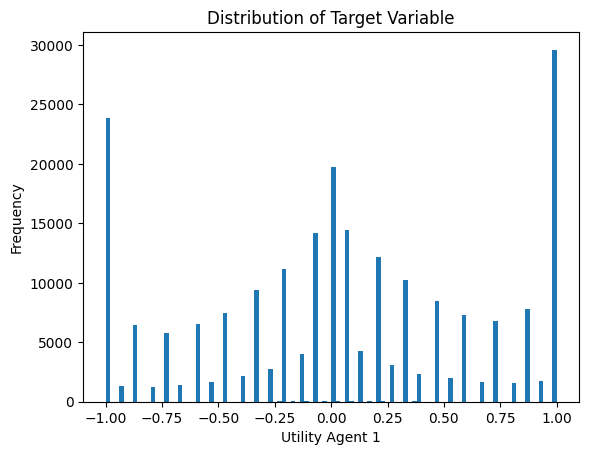

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model


In [9]:
if train_type == "small":
    LEARNING_RATE = 0.08
    NUM_BOOST_ROUND = 2500
elif train_type == "medium":
    LEARNING_RATE = 0.04
    NUM_BOOST_ROUND = 5000
elif train_type == "large":
    LEARNING_RATE = 0.02
    NUM_BOOST_ROUND = 10_000
elif train_type == "xlarge":
    LEARNING_RATE = 0.01
    NUM_BOOST_ROUND = 20_000


print(LEARNING_RATE, NUM_BOOST_ROUND)

0.02 10000


In [10]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        target='utility_agent1',
        split_list=None,
    ):
    # Define the parameters
    params = {
        'objective': "regression",
        'metric': 'rmse',
        'boosting': 'gbdt',
        ###################
        'num_leaves': 31,
        'max_depth': 12,
        'learning_rate': LEARNING_RATE,
        ###################
        'min_data_in_leaf': 100,
        'bagging_freq': 1,
        'bagging_fraction': 0.8,
        'feature_fraction': 0.5,
        'verbose': -1,
        'seed': 2112,
    }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_val = X_train[target], X_val[target]
        
        # Create LightGBM datasets
        train_data = lgb.Dataset(
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            categorical_feature=categorical_cols,
            free_raw_data=True
        )
        val_data = lgb.Dataset(
            data=X_val[numerical_cols + categorical_cols],
            label=y_val,
            categorical_feature=categorical_cols,
            free_raw_data=True
        )

        # Train the model
        model = lgb.train(
            params,
            train_data,
            num_boost_round=NUM_BOOST_ROUND,
            valid_sets=[val_data],
            callbacks=[
                lgb.log_evaluation(period=100),
            ]
        )
        
        # Get feature importance for this fold
        feat_importance = pd.DataFrame({
            'feature': numerical_cols + categorical_cols,
            f'importance_f{fold}': model.feature_importance(importance_type='gain')
        })
        feat_importance_dfs.append(feat_importance)
        
        # Plot feature importance
        lgb.plot_importance(model, figsize=(10, 8), importance_type='gain', max_num_features=50)
        plt.title('Top 50 Features by Importance')
        plt.tight_layout()
        plt.show()
        
        # Save the trained model to the list
        trained_models.append(model)

        # predict on validation set
        y_pred = model.predict(X_val[numerical_cols + categorical_cols])

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_val
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold
        
        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))
    
    return trained_models, oof, oof_scores, importance_df

Fold 1


[100]	valid_0's rmse: 0.49786


[200]	valid_0's rmse: 0.483105


[300]	valid_0's rmse: 0.473058


[400]	valid_0's rmse: 0.466338


[500]	valid_0's rmse: 0.462297


[600]	valid_0's rmse: 0.459218


[700]	valid_0's rmse: 0.4559


[800]	valid_0's rmse: 0.453318


[900]	valid_0's rmse: 0.45098


[1000]	valid_0's rmse: 0.449607


[1100]	valid_0's rmse: 0.447896


[1200]	valid_0's rmse: 0.446475


[1300]	valid_0's rmse: 0.445178


[1400]	valid_0's rmse: 0.444219


[1500]	valid_0's rmse: 0.443293


[1600]	valid_0's rmse: 0.4425


[1700]	valid_0's rmse: 0.441753


[1800]	valid_0's rmse: 0.441185


[1900]	valid_0's rmse: 0.440603


[2000]	valid_0's rmse: 0.440079


[2100]	valid_0's rmse: 0.439452


[2200]	valid_0's rmse: 0.438938


[2300]	valid_0's rmse: 0.438558


[2400]	valid_0's rmse: 0.438111


[2500]	valid_0's rmse: 0.437678


[2600]	valid_0's rmse: 0.437347


[2700]	valid_0's rmse: 0.437127


[2800]	valid_0's rmse: 0.436801


[2900]	valid_0's rmse: 0.436385


[3000]	valid_0's rmse: 0.436168


[3100]	valid_0's rmse: 0.435934


[3200]	valid_0's rmse: 0.435712


[3300]	valid_0's rmse: 0.435444


[3400]	valid_0's rmse: 0.435199


[3500]	valid_0's rmse: 0.435099


[3600]	valid_0's rmse: 0.434986


[3700]	valid_0's rmse: 0.434804


[3800]	valid_0's rmse: 0.434686


[3900]	valid_0's rmse: 0.434494


[4000]	valid_0's rmse: 0.434351


[4100]	valid_0's rmse: 0.434186


[4200]	valid_0's rmse: 0.434104


[4300]	valid_0's rmse: 0.43395


[4400]	valid_0's rmse: 0.433819


[4500]	valid_0's rmse: 0.433685


[4600]	valid_0's rmse: 0.433591


[4700]	valid_0's rmse: 0.433502


[4800]	valid_0's rmse: 0.433435


[4900]	valid_0's rmse: 0.433304


[5000]	valid_0's rmse: 0.433254


[5100]	valid_0's rmse: 0.433225


[5200]	valid_0's rmse: 0.433193


[5300]	valid_0's rmse: 0.433174


[5400]	valid_0's rmse: 0.433152


[5500]	valid_0's rmse: 0.43305


[5600]	valid_0's rmse: 0.432965


[5700]	valid_0's rmse: 0.432881


[5800]	valid_0's rmse: 0.432836


[5900]	valid_0's rmse: 0.432733


[6000]	valid_0's rmse: 0.432619


[6100]	valid_0's rmse: 0.43268


[6200]	valid_0's rmse: 0.432679


[6300]	valid_0's rmse: 0.432648


[6400]	valid_0's rmse: 0.432618


[6500]	valid_0's rmse: 0.432592


[6600]	valid_0's rmse: 0.432564


[6700]	valid_0's rmse: 0.432556


[6800]	valid_0's rmse: 0.432571


[6900]	valid_0's rmse: 0.432509


[7000]	valid_0's rmse: 0.43253


[7100]	valid_0's rmse: 0.432546


[7200]	valid_0's rmse: 0.432502


[7300]	valid_0's rmse: 0.432478


[7400]	valid_0's rmse: 0.432422


[7500]	valid_0's rmse: 0.432476


[7600]	valid_0's rmse: 0.43249


[7700]	valid_0's rmse: 0.432453


[7800]	valid_0's rmse: 0.432489


[7900]	valid_0's rmse: 0.432458


[8000]	valid_0's rmse: 0.432422


[8100]	valid_0's rmse: 0.432406


[8200]	valid_0's rmse: 0.432332


[8300]	valid_0's rmse: 0.432309


[8400]	valid_0's rmse: 0.432323


[8500]	valid_0's rmse: 0.432275


[8600]	valid_0's rmse: 0.432227


[8700]	valid_0's rmse: 0.432203


[8800]	valid_0's rmse: 0.432186


[8900]	valid_0's rmse: 0.432211


[9000]	valid_0's rmse: 0.432175


[9100]	valid_0's rmse: 0.43217


[9200]	valid_0's rmse: 0.432175


[9300]	valid_0's rmse: 0.432162


[9400]	valid_0's rmse: 0.432205


[9500]	valid_0's rmse: 0.432165


[9600]	valid_0's rmse: 0.43213


[9700]	valid_0's rmse: 0.43216


[9800]	valid_0's rmse: 0.432133


[9900]	valid_0's rmse: 0.432106


[10000]	valid_0's rmse: 0.4321


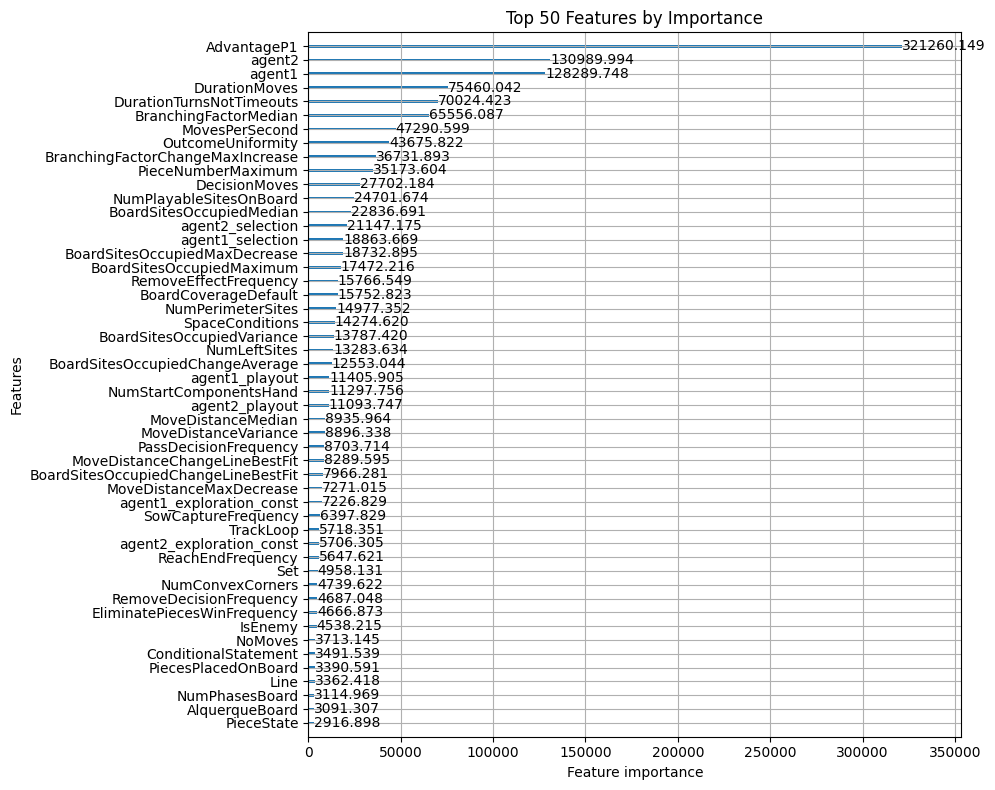

Fold 1 - RMSE: 0.43165126495408507
Fold 2


[100]	valid_0's rmse: 0.509941


[200]	valid_0's rmse: 0.492483


[300]	valid_0's rmse: 0.482347


[400]	valid_0's rmse: 0.475814


[500]	valid_0's rmse: 0.471239


[600]	valid_0's rmse: 0.467783


[700]	valid_0's rmse: 0.464847


[800]	valid_0's rmse: 0.463108


[900]	valid_0's rmse: 0.461275


[1000]	valid_0's rmse: 0.459869


[1100]	valid_0's rmse: 0.458955


[1200]	valid_0's rmse: 0.457647


[1300]	valid_0's rmse: 0.456662


[1400]	valid_0's rmse: 0.455741


[1500]	valid_0's rmse: 0.454858


[1600]	valid_0's rmse: 0.454103


[1700]	valid_0's rmse: 0.453654


[1800]	valid_0's rmse: 0.452838


[1900]	valid_0's rmse: 0.452217


[2000]	valid_0's rmse: 0.451655


[2100]	valid_0's rmse: 0.451388


[2200]	valid_0's rmse: 0.45099


[2300]	valid_0's rmse: 0.450539


[2400]	valid_0's rmse: 0.450282


[2500]	valid_0's rmse: 0.449989


[2600]	valid_0's rmse: 0.449544


[2700]	valid_0's rmse: 0.449316


[2800]	valid_0's rmse: 0.449146


[2900]	valid_0's rmse: 0.448901


[3000]	valid_0's rmse: 0.4487


[3100]	valid_0's rmse: 0.448407


[3200]	valid_0's rmse: 0.448211


[3300]	valid_0's rmse: 0.448039


[3400]	valid_0's rmse: 0.447854


[3500]	valid_0's rmse: 0.447738


[3600]	valid_0's rmse: 0.447596


[3700]	valid_0's rmse: 0.447368


[3800]	valid_0's rmse: 0.447124


[3900]	valid_0's rmse: 0.447031


[4000]	valid_0's rmse: 0.446965


[4100]	valid_0's rmse: 0.446964


[4200]	valid_0's rmse: 0.446734


[4300]	valid_0's rmse: 0.446625


[4400]	valid_0's rmse: 0.446553


[4500]	valid_0's rmse: 0.44649


[4600]	valid_0's rmse: 0.446456


[4700]	valid_0's rmse: 0.44639


[4800]	valid_0's rmse: 0.44638


[4900]	valid_0's rmse: 0.446345


[5000]	valid_0's rmse: 0.446153


[5100]	valid_0's rmse: 0.445942


[5200]	valid_0's rmse: 0.445819


[5300]	valid_0's rmse: 0.445681


[5400]	valid_0's rmse: 0.445594


[5500]	valid_0's rmse: 0.445481


[5600]	valid_0's rmse: 0.445381


[5700]	valid_0's rmse: 0.445264


[5800]	valid_0's rmse: 0.445289


[5900]	valid_0's rmse: 0.445223


[6000]	valid_0's rmse: 0.445084


[6100]	valid_0's rmse: 0.444994


[6200]	valid_0's rmse: 0.444948


[6300]	valid_0's rmse: 0.44476


[6400]	valid_0's rmse: 0.444706


[6500]	valid_0's rmse: 0.444612


[6600]	valid_0's rmse: 0.444611


[6700]	valid_0's rmse: 0.444469


[6800]	valid_0's rmse: 0.444315


[6900]	valid_0's rmse: 0.444254


[7000]	valid_0's rmse: 0.444128


[7100]	valid_0's rmse: 0.444083


[7200]	valid_0's rmse: 0.444011


[7300]	valid_0's rmse: 0.443978


[7400]	valid_0's rmse: 0.443929


[7500]	valid_0's rmse: 0.443981


[7600]	valid_0's rmse: 0.443976


[7700]	valid_0's rmse: 0.443896


[7800]	valid_0's rmse: 0.443817


[7900]	valid_0's rmse: 0.443796


[8000]	valid_0's rmse: 0.443764


[8100]	valid_0's rmse: 0.443621


[8200]	valid_0's rmse: 0.44364


[8300]	valid_0's rmse: 0.443604


[8400]	valid_0's rmse: 0.44351


[8500]	valid_0's rmse: 0.443504


[8600]	valid_0's rmse: 0.443435


[8700]	valid_0's rmse: 0.443398


[8800]	valid_0's rmse: 0.44337


[8900]	valid_0's rmse: 0.443366


[9000]	valid_0's rmse: 0.443294


[9100]	valid_0's rmse: 0.443232


[9200]	valid_0's rmse: 0.443168


[9300]	valid_0's rmse: 0.443111


[9400]	valid_0's rmse: 0.443071


[9500]	valid_0's rmse: 0.443039


[9600]	valid_0's rmse: 0.443026


[9700]	valid_0's rmse: 0.442985


[9800]	valid_0's rmse: 0.442987


[9900]	valid_0's rmse: 0.442972


[10000]	valid_0's rmse: 0.442939


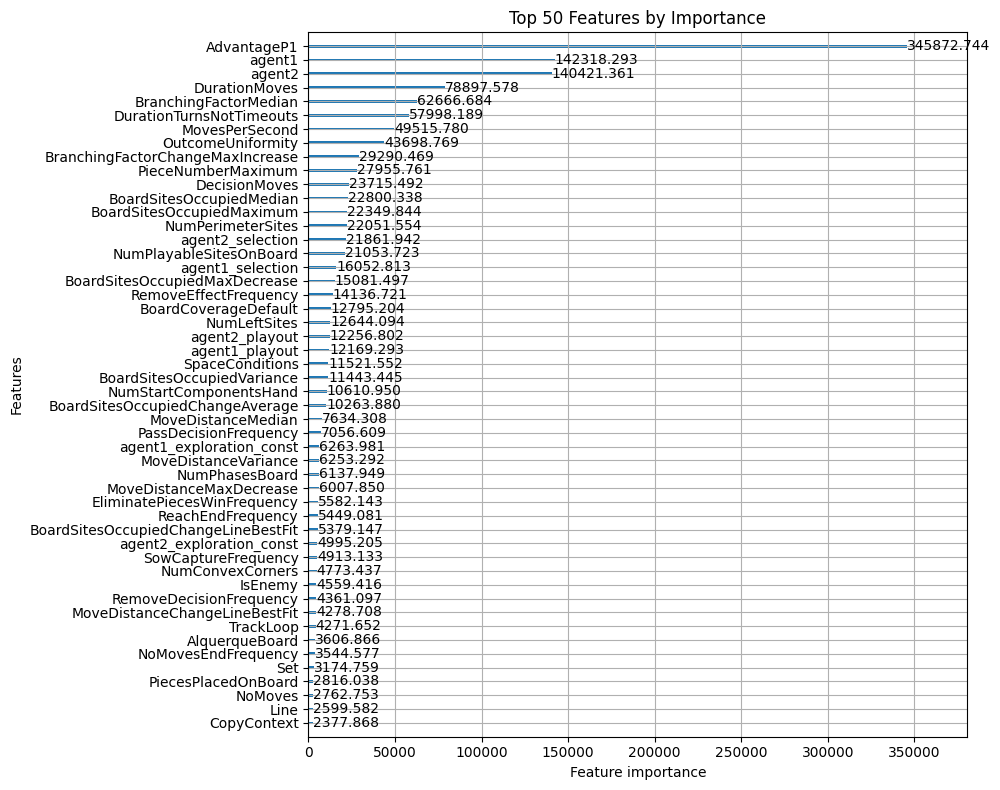

Fold 2 - RMSE: 0.4424490264890833
Fold 3


[100]	valid_0's rmse: 0.499387


[200]	valid_0's rmse: 0.474222


[300]	valid_0's rmse: 0.461617


[400]	valid_0's rmse: 0.45446


[500]	valid_0's rmse: 0.450206


[600]	valid_0's rmse: 0.446627


[700]	valid_0's rmse: 0.44383


[800]	valid_0's rmse: 0.440793


[900]	valid_0's rmse: 0.438848


[1000]	valid_0's rmse: 0.436967


[1100]	valid_0's rmse: 0.435377


[1200]	valid_0's rmse: 0.434357


[1300]	valid_0's rmse: 0.433258


[1400]	valid_0's rmse: 0.432373


[1500]	valid_0's rmse: 0.431685


[1600]	valid_0's rmse: 0.430965


[1700]	valid_0's rmse: 0.430231


[1800]	valid_0's rmse: 0.429368


[1900]	valid_0's rmse: 0.428927


[2000]	valid_0's rmse: 0.428262


[2100]	valid_0's rmse: 0.42771


[2200]	valid_0's rmse: 0.427256


[2300]	valid_0's rmse: 0.426862


[2400]	valid_0's rmse: 0.426416


[2500]	valid_0's rmse: 0.426127


[2600]	valid_0's rmse: 0.425737


[2700]	valid_0's rmse: 0.425325


[2800]	valid_0's rmse: 0.425067


[2900]	valid_0's rmse: 0.424762


[3000]	valid_0's rmse: 0.424608


[3100]	valid_0's rmse: 0.424392


[3200]	valid_0's rmse: 0.42419


[3300]	valid_0's rmse: 0.424071


[3400]	valid_0's rmse: 0.42384


[3500]	valid_0's rmse: 0.423525


[3600]	valid_0's rmse: 0.423262


[3700]	valid_0's rmse: 0.422974


[3800]	valid_0's rmse: 0.422761


[3900]	valid_0's rmse: 0.422608


[4000]	valid_0's rmse: 0.422542


[4100]	valid_0's rmse: 0.422345


[4200]	valid_0's rmse: 0.422228


[4300]	valid_0's rmse: 0.42207


[4400]	valid_0's rmse: 0.421972


[4500]	valid_0's rmse: 0.421876


[4600]	valid_0's rmse: 0.421798


[4700]	valid_0's rmse: 0.421564


[4800]	valid_0's rmse: 0.421481


[4900]	valid_0's rmse: 0.421382


[5000]	valid_0's rmse: 0.421286


[5100]	valid_0's rmse: 0.421188


[5200]	valid_0's rmse: 0.421056


[5300]	valid_0's rmse: 0.42096


[5400]	valid_0's rmse: 0.420831


[5500]	valid_0's rmse: 0.420706


[5600]	valid_0's rmse: 0.420609


[5700]	valid_0's rmse: 0.420552


[5800]	valid_0's rmse: 0.420475


[5900]	valid_0's rmse: 0.420431


[6000]	valid_0's rmse: 0.420397


[6100]	valid_0's rmse: 0.420337


[6200]	valid_0's rmse: 0.420284


[6300]	valid_0's rmse: 0.420273


[6400]	valid_0's rmse: 0.420244


[6500]	valid_0's rmse: 0.420226


[6600]	valid_0's rmse: 0.420175


[6700]	valid_0's rmse: 0.420074


[6800]	valid_0's rmse: 0.42001


[6900]	valid_0's rmse: 0.41991


[7000]	valid_0's rmse: 0.419817


[7100]	valid_0's rmse: 0.419737


[7200]	valid_0's rmse: 0.419646


[7300]	valid_0's rmse: 0.419565


[7400]	valid_0's rmse: 0.419584


[7500]	valid_0's rmse: 0.419525


[7600]	valid_0's rmse: 0.419431


[7700]	valid_0's rmse: 0.419403


[7800]	valid_0's rmse: 0.419311


[7900]	valid_0's rmse: 0.419296


[8000]	valid_0's rmse: 0.41928


[8100]	valid_0's rmse: 0.41916


[8200]	valid_0's rmse: 0.419069


[8300]	valid_0's rmse: 0.41899


[8400]	valid_0's rmse: 0.418887


[8500]	valid_0's rmse: 0.418799


[8600]	valid_0's rmse: 0.418786


[8700]	valid_0's rmse: 0.418778


[8800]	valid_0's rmse: 0.418743


[8900]	valid_0's rmse: 0.418745


[9000]	valid_0's rmse: 0.418652


[9100]	valid_0's rmse: 0.418616


[9200]	valid_0's rmse: 0.418599


[9300]	valid_0's rmse: 0.418568


[9400]	valid_0's rmse: 0.418567


[9500]	valid_0's rmse: 0.418481


[9600]	valid_0's rmse: 0.418415


[9700]	valid_0's rmse: 0.418366


[9800]	valid_0's rmse: 0.418318


[9900]	valid_0's rmse: 0.41835


[10000]	valid_0's rmse: 0.418328


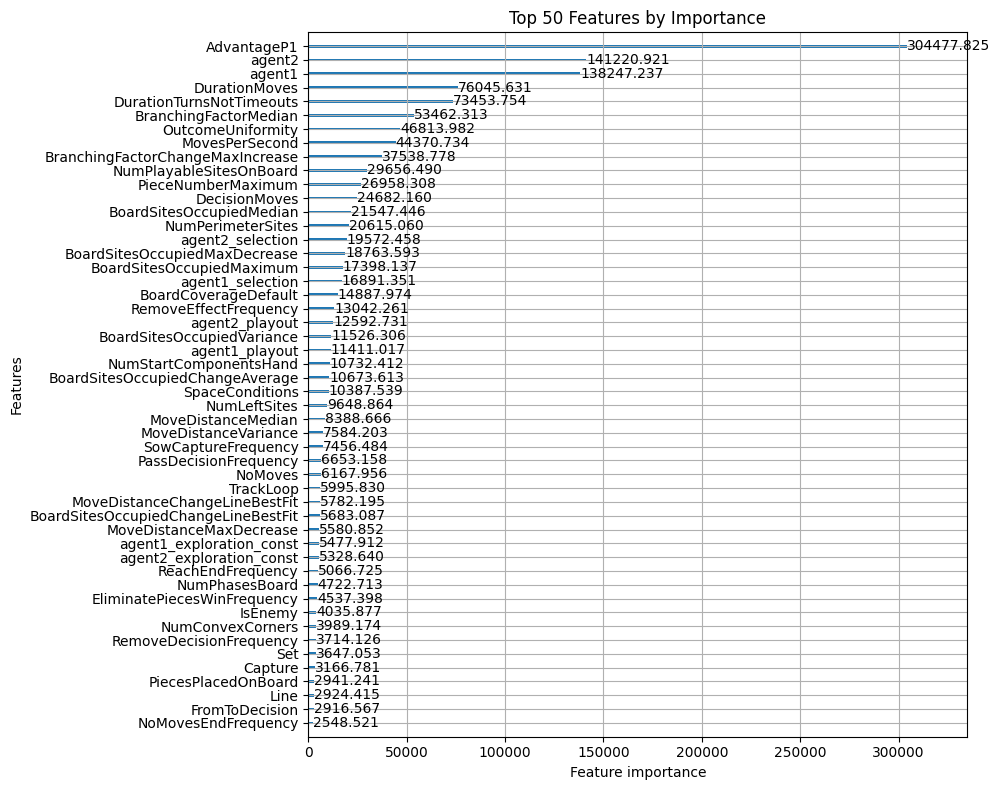

Fold 3 - RMSE: 0.4176266459348185
Fold 4


[100]	valid_0's rmse: 0.510001


[200]	valid_0's rmse: 0.486943


[300]	valid_0's rmse: 0.475537


[400]	valid_0's rmse: 0.467494


[500]	valid_0's rmse: 0.462051


[600]	valid_0's rmse: 0.457717


[700]	valid_0's rmse: 0.454379


[800]	valid_0's rmse: 0.451379


[900]	valid_0's rmse: 0.449424


[1000]	valid_0's rmse: 0.447828


[1100]	valid_0's rmse: 0.446218


[1200]	valid_0's rmse: 0.444931


[1300]	valid_0's rmse: 0.443644


[1400]	valid_0's rmse: 0.442527


[1500]	valid_0's rmse: 0.441637


[1600]	valid_0's rmse: 0.440979


[1700]	valid_0's rmse: 0.440285


[1800]	valid_0's rmse: 0.439605


[1900]	valid_0's rmse: 0.438899


[2000]	valid_0's rmse: 0.438311


[2100]	valid_0's rmse: 0.437913


[2200]	valid_0's rmse: 0.437469


[2300]	valid_0's rmse: 0.436972


[2400]	valid_0's rmse: 0.436616


[2500]	valid_0's rmse: 0.436073


[2600]	valid_0's rmse: 0.4358


[2700]	valid_0's rmse: 0.435433


[2800]	valid_0's rmse: 0.43505


[2900]	valid_0's rmse: 0.434529


[3000]	valid_0's rmse: 0.434216


[3100]	valid_0's rmse: 0.434011


[3200]	valid_0's rmse: 0.433632


[3300]	valid_0's rmse: 0.433406


[3400]	valid_0's rmse: 0.433183


[3500]	valid_0's rmse: 0.432858


[3600]	valid_0's rmse: 0.432686


[3700]	valid_0's rmse: 0.432551


[3800]	valid_0's rmse: 0.432373


[3900]	valid_0's rmse: 0.432204


[4000]	valid_0's rmse: 0.43206


[4100]	valid_0's rmse: 0.4319


[4200]	valid_0's rmse: 0.431661


[4300]	valid_0's rmse: 0.431515


[4400]	valid_0's rmse: 0.431481


[4500]	valid_0's rmse: 0.431415


[4600]	valid_0's rmse: 0.431248


[4700]	valid_0's rmse: 0.431143


[4800]	valid_0's rmse: 0.431005


[4900]	valid_0's rmse: 0.430876


[5000]	valid_0's rmse: 0.430739


[5100]	valid_0's rmse: 0.430651


[5200]	valid_0's rmse: 0.430601


[5300]	valid_0's rmse: 0.430507


[5400]	valid_0's rmse: 0.430377


[5500]	valid_0's rmse: 0.430285


[5600]	valid_0's rmse: 0.43024


[5700]	valid_0's rmse: 0.430131


[5800]	valid_0's rmse: 0.430114


[5900]	valid_0's rmse: 0.429952


[6000]	valid_0's rmse: 0.429942


[6100]	valid_0's rmse: 0.429923


[6200]	valid_0's rmse: 0.429872


[6300]	valid_0's rmse: 0.429796


[6400]	valid_0's rmse: 0.429693


[6500]	valid_0's rmse: 0.429594


[6600]	valid_0's rmse: 0.429546


[6700]	valid_0's rmse: 0.429507


[6800]	valid_0's rmse: 0.429446


[6900]	valid_0's rmse: 0.429342


[7000]	valid_0's rmse: 0.429318


[7100]	valid_0's rmse: 0.429275


[7200]	valid_0's rmse: 0.429223


[7300]	valid_0's rmse: 0.429168


[7400]	valid_0's rmse: 0.429075


[7500]	valid_0's rmse: 0.429074


[7600]	valid_0's rmse: 0.429037


[7700]	valid_0's rmse: 0.42896


[7800]	valid_0's rmse: 0.428971


[7900]	valid_0's rmse: 0.428891


[8000]	valid_0's rmse: 0.42886


[8100]	valid_0's rmse: 0.428813


[8200]	valid_0's rmse: 0.428751


[8300]	valid_0's rmse: 0.428702


[8400]	valid_0's rmse: 0.428739


[8500]	valid_0's rmse: 0.428707


[8600]	valid_0's rmse: 0.428698


[8700]	valid_0's rmse: 0.428658


[8800]	valid_0's rmse: 0.428654


[8900]	valid_0's rmse: 0.428633


[9000]	valid_0's rmse: 0.428609


[9100]	valid_0's rmse: 0.428586


[9200]	valid_0's rmse: 0.428535


[9300]	valid_0's rmse: 0.428515


[9400]	valid_0's rmse: 0.428476


[9500]	valid_0's rmse: 0.428379


[9600]	valid_0's rmse: 0.428362


[9700]	valid_0's rmse: 0.42829


[9800]	valid_0's rmse: 0.42829


[9900]	valid_0's rmse: 0.428303


[10000]	valid_0's rmse: 0.428248


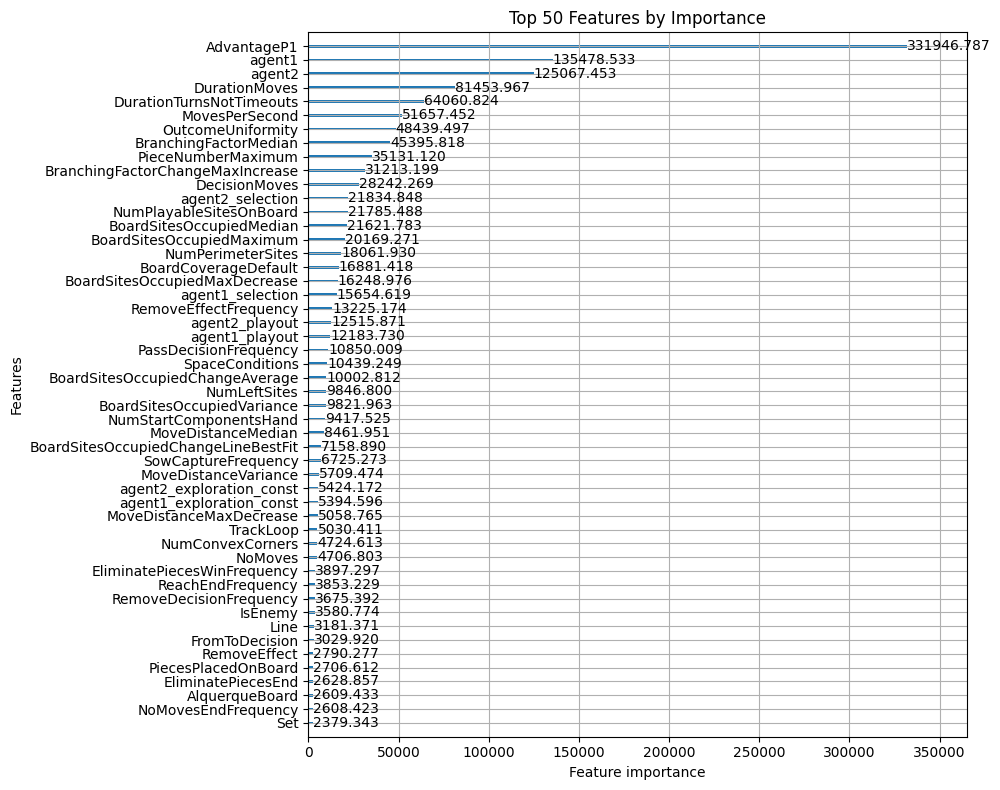

Fold 4 - RMSE: 0.4276375540177375
Fold 5


[100]	valid_0's rmse: 0.488328


[200]	valid_0's rmse: 0.466922


[300]	valid_0's rmse: 0.45576


[400]	valid_0's rmse: 0.447724


[500]	valid_0's rmse: 0.442677


[600]	valid_0's rmse: 0.438898


[700]	valid_0's rmse: 0.435995


[800]	valid_0's rmse: 0.433212


[900]	valid_0's rmse: 0.431126


[1000]	valid_0's rmse: 0.429488


[1100]	valid_0's rmse: 0.427757


[1200]	valid_0's rmse: 0.426167


[1300]	valid_0's rmse: 0.424958


[1400]	valid_0's rmse: 0.42379


[1500]	valid_0's rmse: 0.42282


[1600]	valid_0's rmse: 0.421977


[1700]	valid_0's rmse: 0.421109


[1800]	valid_0's rmse: 0.420224


[1900]	valid_0's rmse: 0.419528


[2000]	valid_0's rmse: 0.418794


[2100]	valid_0's rmse: 0.418427


[2200]	valid_0's rmse: 0.417966


[2300]	valid_0's rmse: 0.417504


[2400]	valid_0's rmse: 0.417099


[2500]	valid_0's rmse: 0.416743


[2600]	valid_0's rmse: 0.416366


[2700]	valid_0's rmse: 0.415974


[2800]	valid_0's rmse: 0.415715


[2900]	valid_0's rmse: 0.415404


[3000]	valid_0's rmse: 0.415119


[3100]	valid_0's rmse: 0.414665


[3200]	valid_0's rmse: 0.414367


[3300]	valid_0's rmse: 0.413989


[3400]	valid_0's rmse: 0.413844


[3500]	valid_0's rmse: 0.413459


[3600]	valid_0's rmse: 0.413125


[3700]	valid_0's rmse: 0.412867


[3800]	valid_0's rmse: 0.412807


[3900]	valid_0's rmse: 0.412604


[4000]	valid_0's rmse: 0.412463


[4100]	valid_0's rmse: 0.412287


[4200]	valid_0's rmse: 0.412187


[4300]	valid_0's rmse: 0.412155


[4400]	valid_0's rmse: 0.411979


[4500]	valid_0's rmse: 0.411879


[4600]	valid_0's rmse: 0.411807


[4700]	valid_0's rmse: 0.411634


[4800]	valid_0's rmse: 0.411538


[4900]	valid_0's rmse: 0.411288


[5000]	valid_0's rmse: 0.411172


[5100]	valid_0's rmse: 0.411111


[5200]	valid_0's rmse: 0.41103


[5300]	valid_0's rmse: 0.410964


[5400]	valid_0's rmse: 0.410851


[5500]	valid_0's rmse: 0.410833


[5600]	valid_0's rmse: 0.410767


[5700]	valid_0's rmse: 0.410738


[5800]	valid_0's rmse: 0.410715


[5900]	valid_0's rmse: 0.410662


[6000]	valid_0's rmse: 0.41063


[6100]	valid_0's rmse: 0.410566


[6200]	valid_0's rmse: 0.410426


[6300]	valid_0's rmse: 0.410336


[6400]	valid_0's rmse: 0.410276


[6500]	valid_0's rmse: 0.410156


[6600]	valid_0's rmse: 0.410082


[6700]	valid_0's rmse: 0.410078


[6800]	valid_0's rmse: 0.410037


[6900]	valid_0's rmse: 0.409932


[7000]	valid_0's rmse: 0.409814


[7100]	valid_0's rmse: 0.409753


[7200]	valid_0's rmse: 0.409732


[7300]	valid_0's rmse: 0.409675


[7400]	valid_0's rmse: 0.409648


[7500]	valid_0's rmse: 0.409664


[7600]	valid_0's rmse: 0.40968


[7700]	valid_0's rmse: 0.409654


[7800]	valid_0's rmse: 0.40963


[7900]	valid_0's rmse: 0.409589


[8000]	valid_0's rmse: 0.409479


[8100]	valid_0's rmse: 0.409442


[8200]	valid_0's rmse: 0.409391


[8300]	valid_0's rmse: 0.409374


[8400]	valid_0's rmse: 0.409379


[8500]	valid_0's rmse: 0.409366


[8600]	valid_0's rmse: 0.409353


[8700]	valid_0's rmse: 0.409308


[8800]	valid_0's rmse: 0.409302


[8900]	valid_0's rmse: 0.409299


[9000]	valid_0's rmse: 0.409274


[9100]	valid_0's rmse: 0.40931


[9200]	valid_0's rmse: 0.409309


[9300]	valid_0's rmse: 0.409276


[9400]	valid_0's rmse: 0.409287


[9500]	valid_0's rmse: 0.40934


[9600]	valid_0's rmse: 0.409343


[9700]	valid_0's rmse: 0.409306


[9800]	valid_0's rmse: 0.409318


[9900]	valid_0's rmse: 0.409308


[10000]	valid_0's rmse: 0.409323


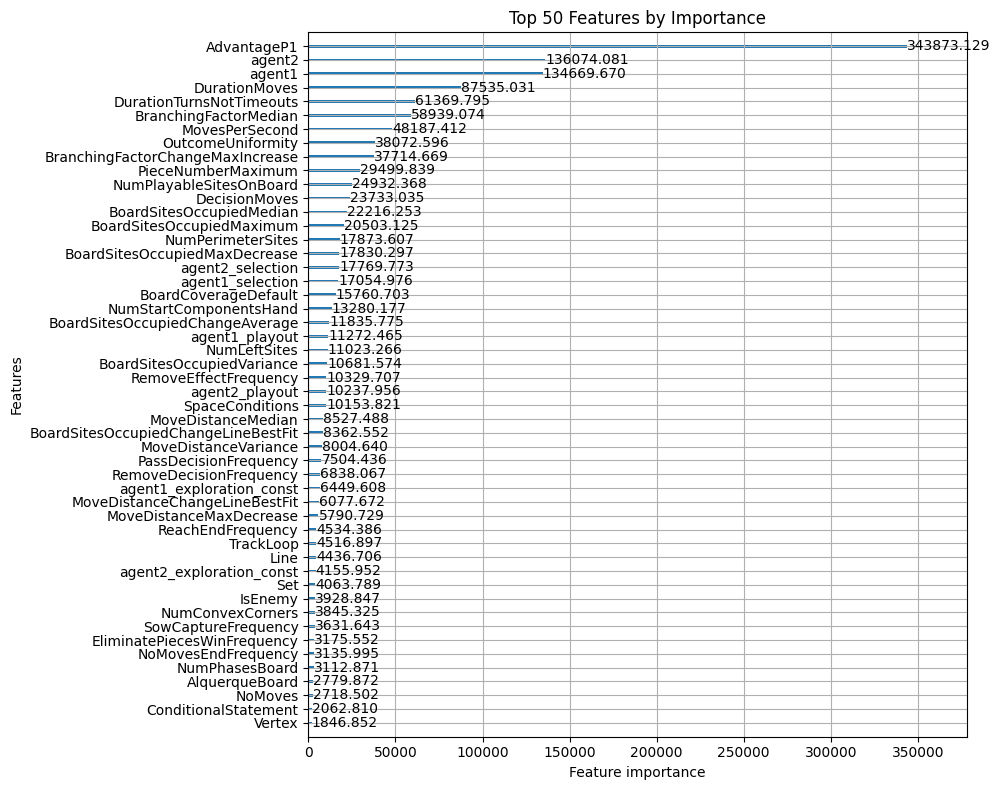

Fold 5 - RMSE: 0.4089745944850798
List of oof scores: [0.43165126495408507, 0.4424490264890833, 0.4176266459348185, 0.4276375540177375, 0.4089745944850798]
Average oof score: 0.42566781717616087


In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv1.parquet', index=False)

Fold 1


[100]	valid_0's rmse: 0.47729


[200]	valid_0's rmse: 0.460289


[300]	valid_0's rmse: 0.451871


[400]	valid_0's rmse: 0.4469


[500]	valid_0's rmse: 0.443182


[600]	valid_0's rmse: 0.440694


[700]	valid_0's rmse: 0.438828


[800]	valid_0's rmse: 0.436676


[900]	valid_0's rmse: 0.435012


[1000]	valid_0's rmse: 0.433405


[1100]	valid_0's rmse: 0.432135


[1200]	valid_0's rmse: 0.431027


[1300]	valid_0's rmse: 0.430074


[1400]	valid_0's rmse: 0.429405


[1500]	valid_0's rmse: 0.428814


[1600]	valid_0's rmse: 0.428122


[1700]	valid_0's rmse: 0.427644


[1800]	valid_0's rmse: 0.426958


[1900]	valid_0's rmse: 0.426463


[2000]	valid_0's rmse: 0.426227


[2100]	valid_0's rmse: 0.425692


[2200]	valid_0's rmse: 0.425255


[2300]	valid_0's rmse: 0.424835


[2400]	valid_0's rmse: 0.424482


[2500]	valid_0's rmse: 0.424181


[2600]	valid_0's rmse: 0.423992


[2700]	valid_0's rmse: 0.423613


[2800]	valid_0's rmse: 0.423418


[2900]	valid_0's rmse: 0.42321


[3000]	valid_0's rmse: 0.422954


[3100]	valid_0's rmse: 0.422757


[3200]	valid_0's rmse: 0.422493


[3300]	valid_0's rmse: 0.422288


[3400]	valid_0's rmse: 0.422124


[3500]	valid_0's rmse: 0.421926


[3600]	valid_0's rmse: 0.421887


[3700]	valid_0's rmse: 0.421733


[3800]	valid_0's rmse: 0.421475


[3900]	valid_0's rmse: 0.421306


[4000]	valid_0's rmse: 0.421117


[4100]	valid_0's rmse: 0.420923


[4200]	valid_0's rmse: 0.42086


[4300]	valid_0's rmse: 0.420716


[4400]	valid_0's rmse: 0.420569


[4500]	valid_0's rmse: 0.420432


[4600]	valid_0's rmse: 0.420359


[4700]	valid_0's rmse: 0.420227


[4800]	valid_0's rmse: 0.420145


[4900]	valid_0's rmse: 0.420071


[5000]	valid_0's rmse: 0.419965


[5100]	valid_0's rmse: 0.419846


[5200]	valid_0's rmse: 0.419747


[5300]	valid_0's rmse: 0.419691


[5400]	valid_0's rmse: 0.419697


[5500]	valid_0's rmse: 0.419636


[5600]	valid_0's rmse: 0.419611


[5700]	valid_0's rmse: 0.419549


[5800]	valid_0's rmse: 0.419459


[5900]	valid_0's rmse: 0.41939


[6000]	valid_0's rmse: 0.419294


[6100]	valid_0's rmse: 0.419119


[6200]	valid_0's rmse: 0.419024


[6300]	valid_0's rmse: 0.418962


[6400]	valid_0's rmse: 0.418961


[6500]	valid_0's rmse: 0.418852


[6600]	valid_0's rmse: 0.418796


[6700]	valid_0's rmse: 0.418726


[6800]	valid_0's rmse: 0.418699


[6900]	valid_0's rmse: 0.418643


[7000]	valid_0's rmse: 0.418604


[7100]	valid_0's rmse: 0.418558


[7200]	valid_0's rmse: 0.418531


[7300]	valid_0's rmse: 0.418486


[7400]	valid_0's rmse: 0.41845


[7500]	valid_0's rmse: 0.41839


[7600]	valid_0's rmse: 0.418421


[7700]	valid_0's rmse: 0.41843


[7800]	valid_0's rmse: 0.41842


[7900]	valid_0's rmse: 0.418385


[8000]	valid_0's rmse: 0.418347


[8100]	valid_0's rmse: 0.418306


[8200]	valid_0's rmse: 0.418234


[8300]	valid_0's rmse: 0.4182


[8400]	valid_0's rmse: 0.418174


[8500]	valid_0's rmse: 0.418139


[8600]	valid_0's rmse: 0.418157


[8700]	valid_0's rmse: 0.418169


[8800]	valid_0's rmse: 0.418148


[8900]	valid_0's rmse: 0.418121


[9000]	valid_0's rmse: 0.418102


[9100]	valid_0's rmse: 0.418058


[9200]	valid_0's rmse: 0.41801


[9300]	valid_0's rmse: 0.417975


[9400]	valid_0's rmse: 0.417949


[9500]	valid_0's rmse: 0.417915


[9600]	valid_0's rmse: 0.417902


[9700]	valid_0's rmse: 0.417875


[9800]	valid_0's rmse: 0.417857


[9900]	valid_0's rmse: 0.417856


[10000]	valid_0's rmse: 0.41788


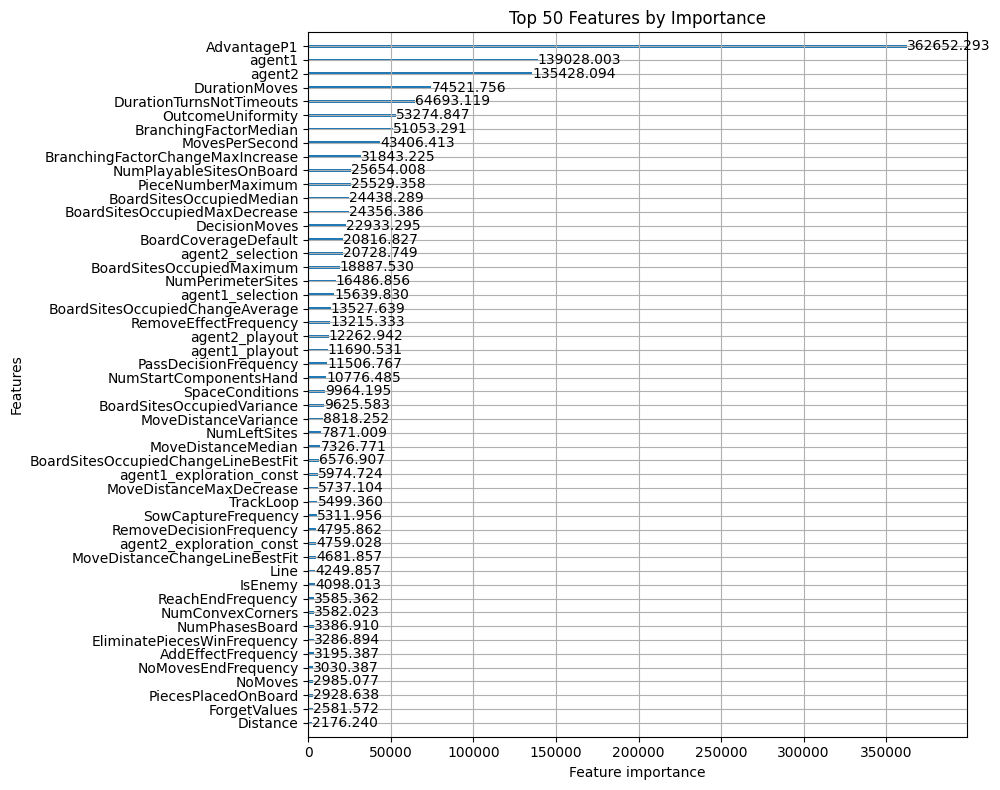

Fold 1 - RMSE: 0.4173248580178951
Fold 2


[100]	valid_0's rmse: 0.459994


[200]	valid_0's rmse: 0.440041


[300]	valid_0's rmse: 0.430689


[400]	valid_0's rmse: 0.425079


[500]	valid_0's rmse: 0.421525


[600]	valid_0's rmse: 0.419578


[700]	valid_0's rmse: 0.417826


[800]	valid_0's rmse: 0.41622


[900]	valid_0's rmse: 0.414452


[1000]	valid_0's rmse: 0.413454


[1100]	valid_0's rmse: 0.412513


[1200]	valid_0's rmse: 0.411648


[1300]	valid_0's rmse: 0.410912


[1400]	valid_0's rmse: 0.410342


[1500]	valid_0's rmse: 0.409914


[1600]	valid_0's rmse: 0.409367


[1700]	valid_0's rmse: 0.408944


[1800]	valid_0's rmse: 0.408459


[1900]	valid_0's rmse: 0.408026


[2000]	valid_0's rmse: 0.407628


[2100]	valid_0's rmse: 0.407411


[2200]	valid_0's rmse: 0.407109


[2300]	valid_0's rmse: 0.406967


[2400]	valid_0's rmse: 0.406729


[2500]	valid_0's rmse: 0.40648


[2600]	valid_0's rmse: 0.406323


[2700]	valid_0's rmse: 0.406101


[2800]	valid_0's rmse: 0.405894


[2900]	valid_0's rmse: 0.40577


[3000]	valid_0's rmse: 0.405551


[3100]	valid_0's rmse: 0.405507


[3200]	valid_0's rmse: 0.405258


[3300]	valid_0's rmse: 0.405064


[3400]	valid_0's rmse: 0.404969


[3500]	valid_0's rmse: 0.404841


[3600]	valid_0's rmse: 0.404711


[3700]	valid_0's rmse: 0.404633


[3800]	valid_0's rmse: 0.404563


[3900]	valid_0's rmse: 0.404546


[4000]	valid_0's rmse: 0.404549


[4100]	valid_0's rmse: 0.404398


[4200]	valid_0's rmse: 0.404375


[4300]	valid_0's rmse: 0.404345


[4400]	valid_0's rmse: 0.404338


[4500]	valid_0's rmse: 0.404282


[4600]	valid_0's rmse: 0.404288


[4700]	valid_0's rmse: 0.404263


[4800]	valid_0's rmse: 0.404133


[4900]	valid_0's rmse: 0.404095


[5000]	valid_0's rmse: 0.404107


[5100]	valid_0's rmse: 0.404076


[5200]	valid_0's rmse: 0.403987


[5300]	valid_0's rmse: 0.403974


[5400]	valid_0's rmse: 0.403937


[5500]	valid_0's rmse: 0.403888


[5600]	valid_0's rmse: 0.403947


[5700]	valid_0's rmse: 0.403881


[5800]	valid_0's rmse: 0.403865


[5900]	valid_0's rmse: 0.403879


[6000]	valid_0's rmse: 0.403881


[6100]	valid_0's rmse: 0.403906


[6200]	valid_0's rmse: 0.403892


[6300]	valid_0's rmse: 0.403938


[6400]	valid_0's rmse: 0.40393


[6500]	valid_0's rmse: 0.403923


[6600]	valid_0's rmse: 0.403873


[6700]	valid_0's rmse: 0.40389


[6800]	valid_0's rmse: 0.403908


[6900]	valid_0's rmse: 0.40392


[7000]	valid_0's rmse: 0.403908


[7100]	valid_0's rmse: 0.403896


[7200]	valid_0's rmse: 0.403932


[7300]	valid_0's rmse: 0.403946


[7400]	valid_0's rmse: 0.403943


[7500]	valid_0's rmse: 0.403994


[7600]	valid_0's rmse: 0.403988


[7700]	valid_0's rmse: 0.403978


[7800]	valid_0's rmse: 0.403977


[7900]	valid_0's rmse: 0.403928


[8000]	valid_0's rmse: 0.403973


[8100]	valid_0's rmse: 0.404009


[8200]	valid_0's rmse: 0.404015


[8300]	valid_0's rmse: 0.403978


[8400]	valid_0's rmse: 0.403954


[8500]	valid_0's rmse: 0.403934


[8600]	valid_0's rmse: 0.403983


[8700]	valid_0's rmse: 0.403994


[8800]	valid_0's rmse: 0.403974


[8900]	valid_0's rmse: 0.403986


[9000]	valid_0's rmse: 0.403998


[9100]	valid_0's rmse: 0.404058


[9200]	valid_0's rmse: 0.40408


[9300]	valid_0's rmse: 0.404082


[9400]	valid_0's rmse: 0.404109


[9500]	valid_0's rmse: 0.404103


[9600]	valid_0's rmse: 0.40418


[9700]	valid_0's rmse: 0.404196


[9800]	valid_0's rmse: 0.404213


[9900]	valid_0's rmse: 0.404213


[10000]	valid_0's rmse: 0.404242


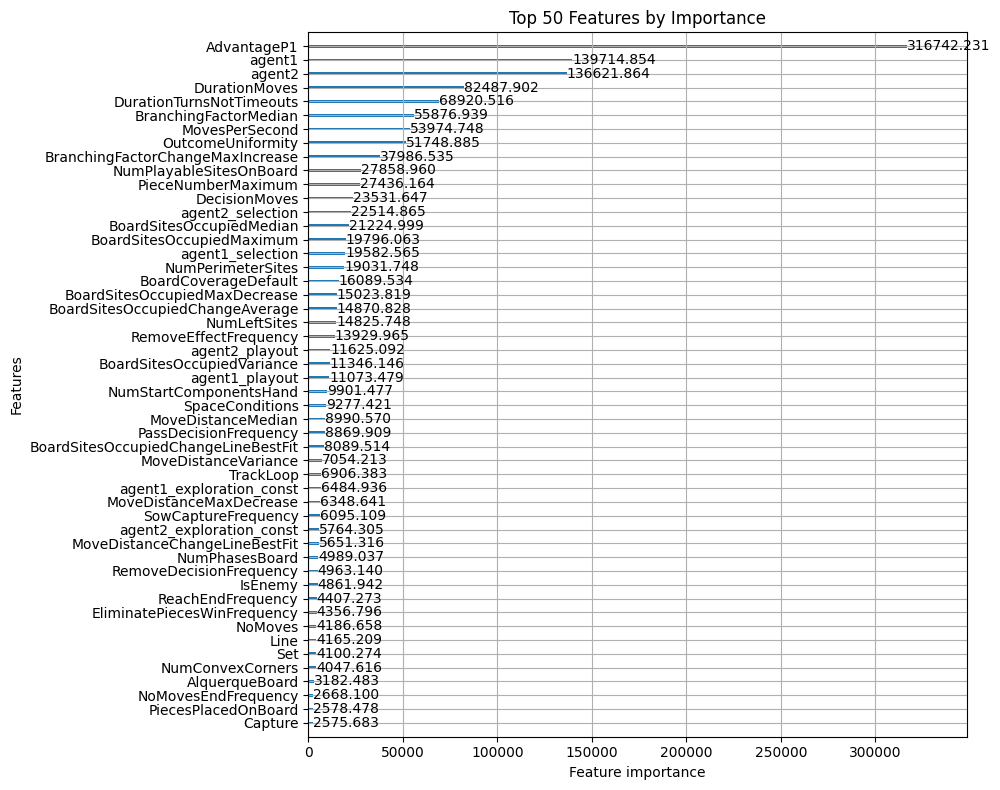

Fold 2 - RMSE: 0.40364890998878067
Fold 3


[100]	valid_0's rmse: 0.524956


[200]	valid_0's rmse: 0.497756


[300]	valid_0's rmse: 0.484455


[400]	valid_0's rmse: 0.4755


[500]	valid_0's rmse: 0.468533


[600]	valid_0's rmse: 0.464107


[700]	valid_0's rmse: 0.460371


[800]	valid_0's rmse: 0.457773


[900]	valid_0's rmse: 0.455492


[1000]	valid_0's rmse: 0.453231


[1100]	valid_0's rmse: 0.451652


[1200]	valid_0's rmse: 0.450152


[1300]	valid_0's rmse: 0.448946


[1400]	valid_0's rmse: 0.447809


[1500]	valid_0's rmse: 0.446894


[1600]	valid_0's rmse: 0.445946


[1700]	valid_0's rmse: 0.445172


[1800]	valid_0's rmse: 0.444468


[1900]	valid_0's rmse: 0.443798


[2000]	valid_0's rmse: 0.443066


[2100]	valid_0's rmse: 0.442644


[2200]	valid_0's rmse: 0.442173


[2300]	valid_0's rmse: 0.441502


[2400]	valid_0's rmse: 0.441013


[2500]	valid_0's rmse: 0.440496


[2600]	valid_0's rmse: 0.440191


[2700]	valid_0's rmse: 0.43985


[2800]	valid_0's rmse: 0.439415


[2900]	valid_0's rmse: 0.439


[3000]	valid_0's rmse: 0.438551


[3100]	valid_0's rmse: 0.43828


[3200]	valid_0's rmse: 0.438089


[3300]	valid_0's rmse: 0.437787


[3400]	valid_0's rmse: 0.437602


[3500]	valid_0's rmse: 0.437266


[3600]	valid_0's rmse: 0.437033


[3700]	valid_0's rmse: 0.436766


[3800]	valid_0's rmse: 0.43651


[3900]	valid_0's rmse: 0.436275


[4000]	valid_0's rmse: 0.436022


[4100]	valid_0's rmse: 0.435802


[4200]	valid_0's rmse: 0.435628


[4300]	valid_0's rmse: 0.435371


[4400]	valid_0's rmse: 0.435219


[4500]	valid_0's rmse: 0.434989


[4600]	valid_0's rmse: 0.434725


[4700]	valid_0's rmse: 0.434568


[4800]	valid_0's rmse: 0.434495


[4900]	valid_0's rmse: 0.434354


[5000]	valid_0's rmse: 0.434198


[5100]	valid_0's rmse: 0.434019


[5200]	valid_0's rmse: 0.433838


[5300]	valid_0's rmse: 0.433752


[5400]	valid_0's rmse: 0.433563


[5500]	valid_0's rmse: 0.43356


[5600]	valid_0's rmse: 0.433396


[5700]	valid_0's rmse: 0.433269


[5800]	valid_0's rmse: 0.433249


[5900]	valid_0's rmse: 0.43309


[6000]	valid_0's rmse: 0.433055


[6100]	valid_0's rmse: 0.432954


[6200]	valid_0's rmse: 0.432845


[6300]	valid_0's rmse: 0.432804


[6400]	valid_0's rmse: 0.432736


[6500]	valid_0's rmse: 0.432697


[6600]	valid_0's rmse: 0.432611


[6700]	valid_0's rmse: 0.432558


[6800]	valid_0's rmse: 0.432558


[6900]	valid_0's rmse: 0.432451


[7000]	valid_0's rmse: 0.432331


[7100]	valid_0's rmse: 0.432268


[7200]	valid_0's rmse: 0.432204


[7300]	valid_0's rmse: 0.432144


[7400]	valid_0's rmse: 0.432104


[7500]	valid_0's rmse: 0.432047


[7600]	valid_0's rmse: 0.431987


[7700]	valid_0's rmse: 0.431953


[7800]	valid_0's rmse: 0.431896


[7900]	valid_0's rmse: 0.431833


[8000]	valid_0's rmse: 0.431793


[8100]	valid_0's rmse: 0.431795


[8200]	valid_0's rmse: 0.43181


[8300]	valid_0's rmse: 0.431754


[8400]	valid_0's rmse: 0.431743


[8500]	valid_0's rmse: 0.431705


[8600]	valid_0's rmse: 0.431662


[8700]	valid_0's rmse: 0.431546


[8800]	valid_0's rmse: 0.431498


[8900]	valid_0's rmse: 0.431453


[9000]	valid_0's rmse: 0.431444


[9100]	valid_0's rmse: 0.431373


[9200]	valid_0's rmse: 0.431318


[9300]	valid_0's rmse: 0.431277


[9400]	valid_0's rmse: 0.431297


[9500]	valid_0's rmse: 0.431259


[9600]	valid_0's rmse: 0.431201


[9700]	valid_0's rmse: 0.431213


[9800]	valid_0's rmse: 0.431154


[9900]	valid_0's rmse: 0.431167


[10000]	valid_0's rmse: 0.431192


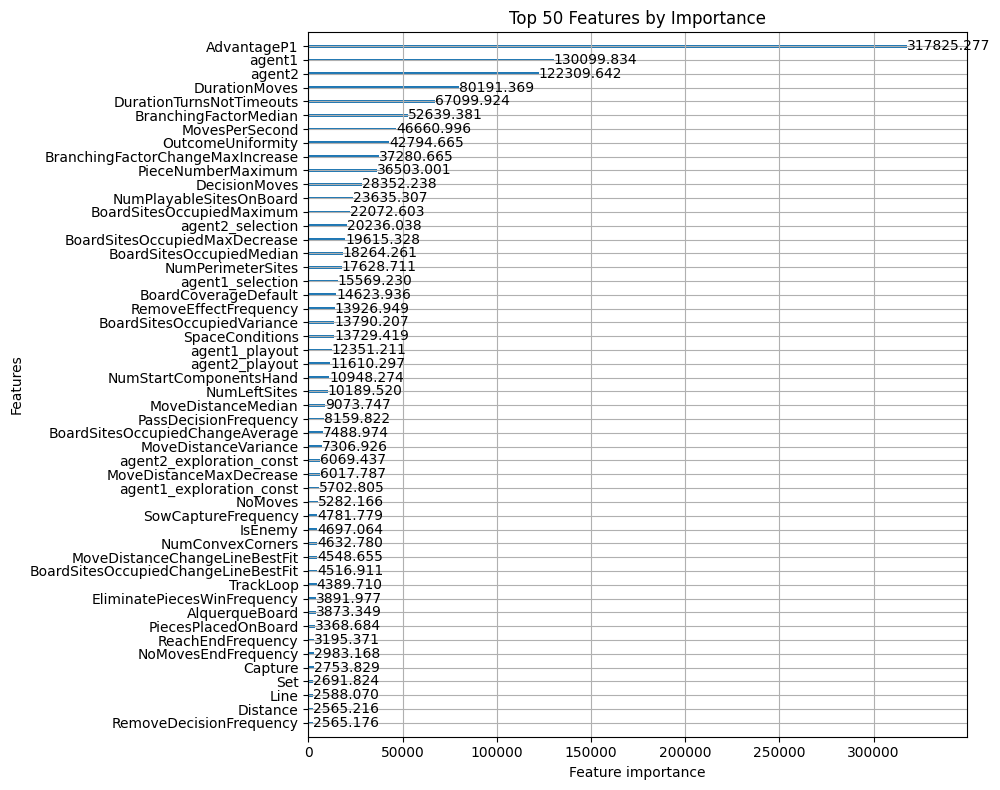

Fold 3 - RMSE: 0.43057761995367555
Fold 4


[100]	valid_0's rmse: 0.518286


[200]	valid_0's rmse: 0.491853


[300]	valid_0's rmse: 0.478405


[400]	valid_0's rmse: 0.470471


[500]	valid_0's rmse: 0.464804


[600]	valid_0's rmse: 0.461398


[700]	valid_0's rmse: 0.458359


[800]	valid_0's rmse: 0.455684


[900]	valid_0's rmse: 0.453601


[1000]	valid_0's rmse: 0.452059


[1100]	valid_0's rmse: 0.451132


[1200]	valid_0's rmse: 0.44964


[1300]	valid_0's rmse: 0.448425


[1400]	valid_0's rmse: 0.44748


[1500]	valid_0's rmse: 0.446641


[1600]	valid_0's rmse: 0.446095


[1700]	valid_0's rmse: 0.445403


[1800]	valid_0's rmse: 0.444875


[1900]	valid_0's rmse: 0.44444


[2000]	valid_0's rmse: 0.443944


[2100]	valid_0's rmse: 0.443491


[2200]	valid_0's rmse: 0.443013


[2300]	valid_0's rmse: 0.442618


[2400]	valid_0's rmse: 0.442247


[2500]	valid_0's rmse: 0.44185


[2600]	valid_0's rmse: 0.441559


[2700]	valid_0's rmse: 0.441241


[2800]	valid_0's rmse: 0.440926


[2900]	valid_0's rmse: 0.440596


[3000]	valid_0's rmse: 0.440363


[3100]	valid_0's rmse: 0.440217


[3200]	valid_0's rmse: 0.439974


[3300]	valid_0's rmse: 0.439762


[3400]	valid_0's rmse: 0.43945


[3500]	valid_0's rmse: 0.439257


[3600]	valid_0's rmse: 0.439051


[3700]	valid_0's rmse: 0.438882


[3800]	valid_0's rmse: 0.438718


[3900]	valid_0's rmse: 0.438518


[4000]	valid_0's rmse: 0.438267


[4100]	valid_0's rmse: 0.438131


[4200]	valid_0's rmse: 0.437961


[4300]	valid_0's rmse: 0.437813


[4400]	valid_0's rmse: 0.43766


[4500]	valid_0's rmse: 0.437546


[4600]	valid_0's rmse: 0.437519


[4700]	valid_0's rmse: 0.437338


[4800]	valid_0's rmse: 0.437247


[4900]	valid_0's rmse: 0.437197


[5000]	valid_0's rmse: 0.437067


[5100]	valid_0's rmse: 0.436964


[5200]	valid_0's rmse: 0.436866


[5300]	valid_0's rmse: 0.436853


[5400]	valid_0's rmse: 0.436767


[5500]	valid_0's rmse: 0.436531


[5600]	valid_0's rmse: 0.436467


[5700]	valid_0's rmse: 0.436432


[5800]	valid_0's rmse: 0.436423


[5900]	valid_0's rmse: 0.436356


[6000]	valid_0's rmse: 0.436276


[6100]	valid_0's rmse: 0.436267


[6200]	valid_0's rmse: 0.436184


[6300]	valid_0's rmse: 0.436042


[6400]	valid_0's rmse: 0.436115


[6500]	valid_0's rmse: 0.43609


[6600]	valid_0's rmse: 0.436027


[6700]	valid_0's rmse: 0.435993


[6800]	valid_0's rmse: 0.436031


[6900]	valid_0's rmse: 0.436009


[7000]	valid_0's rmse: 0.436021


[7100]	valid_0's rmse: 0.435957


[7200]	valid_0's rmse: 0.435913


[7300]	valid_0's rmse: 0.435826


[7400]	valid_0's rmse: 0.435784


[7500]	valid_0's rmse: 0.435714


[7600]	valid_0's rmse: 0.435706


[7700]	valid_0's rmse: 0.435642


[7800]	valid_0's rmse: 0.435617


[7900]	valid_0's rmse: 0.435591


[8000]	valid_0's rmse: 0.435508


[8100]	valid_0's rmse: 0.435484


[8200]	valid_0's rmse: 0.435415


[8300]	valid_0's rmse: 0.435464


[8400]	valid_0's rmse: 0.435438


[8500]	valid_0's rmse: 0.435417


[8600]	valid_0's rmse: 0.435437


[8700]	valid_0's rmse: 0.43542


[8800]	valid_0's rmse: 0.435375


[8900]	valid_0's rmse: 0.435346


[9000]	valid_0's rmse: 0.435325


[9100]	valid_0's rmse: 0.435337


[9200]	valid_0's rmse: 0.435382


[9300]	valid_0's rmse: 0.43531


[9400]	valid_0's rmse: 0.435312


[9500]	valid_0's rmse: 0.435265


[9600]	valid_0's rmse: 0.435234


[9700]	valid_0's rmse: 0.435249


[9800]	valid_0's rmse: 0.435243


[9900]	valid_0's rmse: 0.435234


[10000]	valid_0's rmse: 0.435265


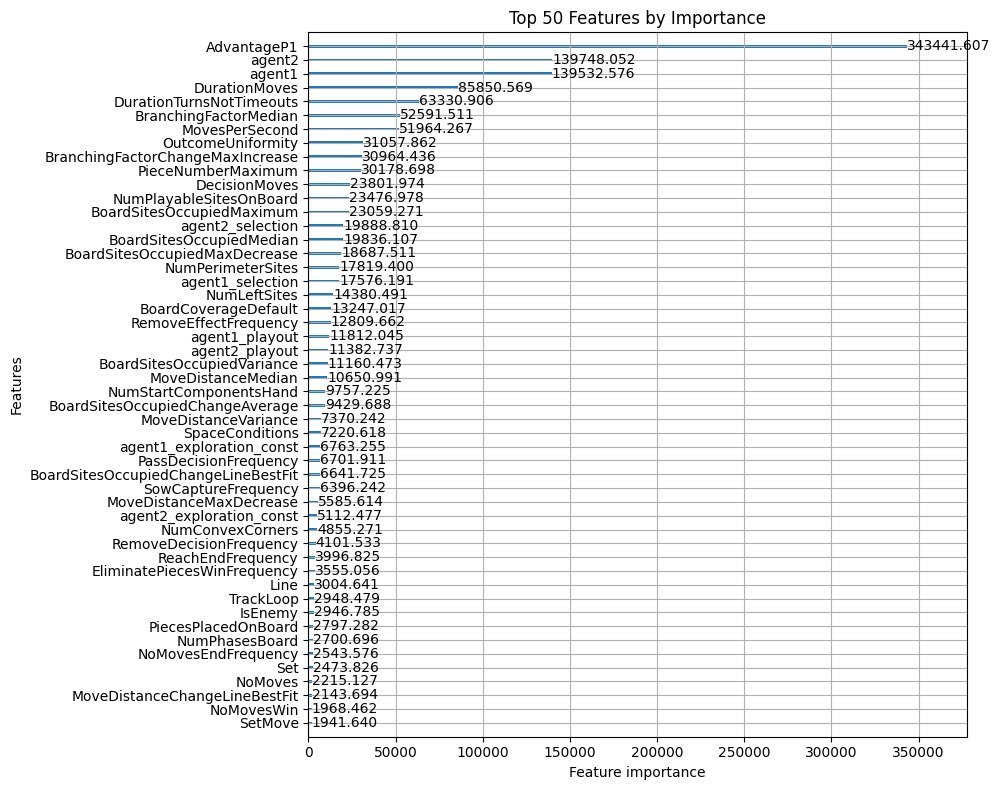

Fold 4 - RMSE: 0.43480541477070495
Fold 5


[100]	valid_0's rmse: 0.514787


[200]	valid_0's rmse: 0.491729


[300]	valid_0's rmse: 0.478282


[400]	valid_0's rmse: 0.471071


[500]	valid_0's rmse: 0.464646


[600]	valid_0's rmse: 0.459782


[700]	valid_0's rmse: 0.456178


[800]	valid_0's rmse: 0.453181


[900]	valid_0's rmse: 0.450509


[1000]	valid_0's rmse: 0.448459


[1100]	valid_0's rmse: 0.446673


[1200]	valid_0's rmse: 0.445373


[1300]	valid_0's rmse: 0.444214


[1400]	valid_0's rmse: 0.443249


[1500]	valid_0's rmse: 0.442225


[1600]	valid_0's rmse: 0.441334


[1700]	valid_0's rmse: 0.440598


[1800]	valid_0's rmse: 0.439842


[1900]	valid_0's rmse: 0.438902


[2000]	valid_0's rmse: 0.43796


[2100]	valid_0's rmse: 0.437444


[2200]	valid_0's rmse: 0.436845


[2300]	valid_0's rmse: 0.436383


[2400]	valid_0's rmse: 0.435757


[2500]	valid_0's rmse: 0.43532


[2600]	valid_0's rmse: 0.434895


[2700]	valid_0's rmse: 0.434485


[2800]	valid_0's rmse: 0.434141


[2900]	valid_0's rmse: 0.433703


[3000]	valid_0's rmse: 0.433389


[3100]	valid_0's rmse: 0.433093


[3200]	valid_0's rmse: 0.432767


[3300]	valid_0's rmse: 0.432338


[3400]	valid_0's rmse: 0.432077


[3500]	valid_0's rmse: 0.431909


[3600]	valid_0's rmse: 0.431762


[3700]	valid_0's rmse: 0.431579


[3800]	valid_0's rmse: 0.431427


[3900]	valid_0's rmse: 0.431214


[4000]	valid_0's rmse: 0.431092


[4100]	valid_0's rmse: 0.430821


[4200]	valid_0's rmse: 0.430628


[4300]	valid_0's rmse: 0.430405


[4400]	valid_0's rmse: 0.430269


[4500]	valid_0's rmse: 0.430033


[4600]	valid_0's rmse: 0.429903


[4700]	valid_0's rmse: 0.429802


[4800]	valid_0's rmse: 0.429554


[4900]	valid_0's rmse: 0.429426


[5000]	valid_0's rmse: 0.429351


[5100]	valid_0's rmse: 0.429342


[5200]	valid_0's rmse: 0.429253


[5300]	valid_0's rmse: 0.429098


[5400]	valid_0's rmse: 0.42894


[5500]	valid_0's rmse: 0.428889


[5600]	valid_0's rmse: 0.428816


[5700]	valid_0's rmse: 0.428768


[5800]	valid_0's rmse: 0.428668


[5900]	valid_0's rmse: 0.428524


[6000]	valid_0's rmse: 0.428469


[6100]	valid_0's rmse: 0.428363


[6200]	valid_0's rmse: 0.428336


[6300]	valid_0's rmse: 0.428174


[6400]	valid_0's rmse: 0.428047


[6500]	valid_0's rmse: 0.428003


[6600]	valid_0's rmse: 0.427998


[6700]	valid_0's rmse: 0.427882


[6800]	valid_0's rmse: 0.427814


[6900]	valid_0's rmse: 0.427799


[7000]	valid_0's rmse: 0.427661


[7100]	valid_0's rmse: 0.427617


[7200]	valid_0's rmse: 0.42763


[7300]	valid_0's rmse: 0.427663


[7400]	valid_0's rmse: 0.427541


[7500]	valid_0's rmse: 0.427534


[7600]	valid_0's rmse: 0.427448


[7700]	valid_0's rmse: 0.42743


[7800]	valid_0's rmse: 0.427383


[7900]	valid_0's rmse: 0.427362


[8000]	valid_0's rmse: 0.427352


[8100]	valid_0's rmse: 0.42732


[8200]	valid_0's rmse: 0.427248


[8300]	valid_0's rmse: 0.427224


[8400]	valid_0's rmse: 0.427244


[8500]	valid_0's rmse: 0.427199


[8600]	valid_0's rmse: 0.427165


[8700]	valid_0's rmse: 0.427044


[8800]	valid_0's rmse: 0.426975


[8900]	valid_0's rmse: 0.426946


[9000]	valid_0's rmse: 0.426856


[9100]	valid_0's rmse: 0.426818


[9200]	valid_0's rmse: 0.426734


[9300]	valid_0's rmse: 0.426657


[9400]	valid_0's rmse: 0.426707


[9500]	valid_0's rmse: 0.42668


[9600]	valid_0's rmse: 0.426706


[9700]	valid_0's rmse: 0.426658


[9800]	valid_0's rmse: 0.426624


[9900]	valid_0's rmse: 0.426586


[10000]	valid_0's rmse: 0.42655


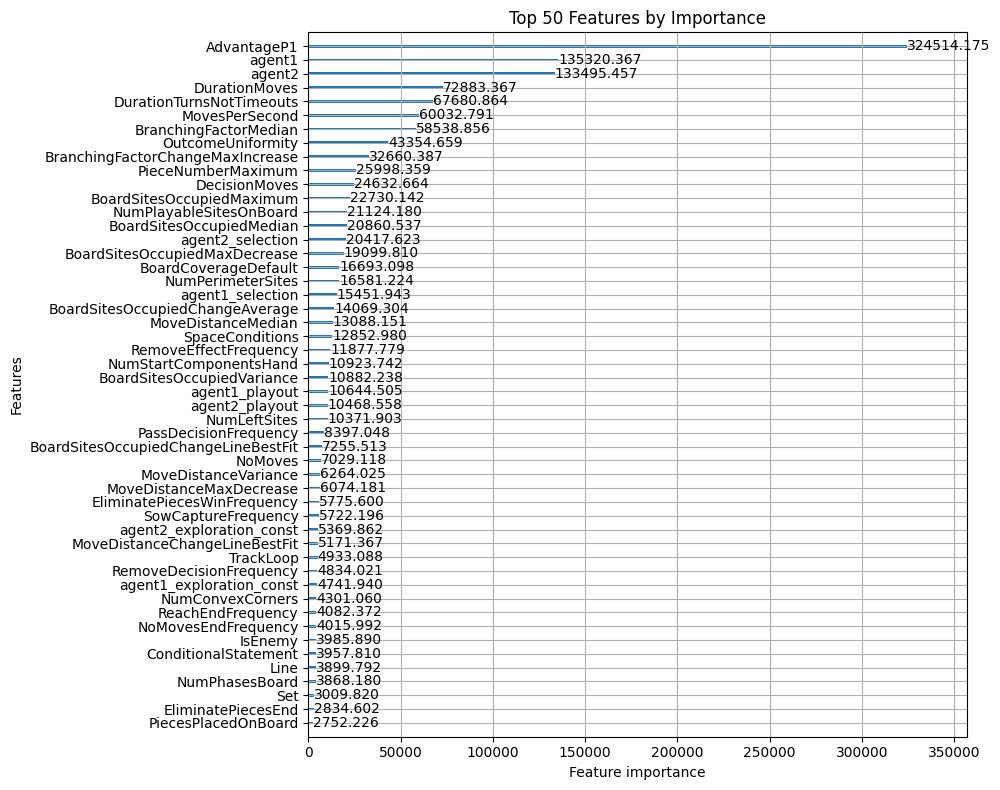

Fold 5 - RMSE: 0.4259929356003832
List of oof scores: [0.4173248580178951, 0.40364890998878067, 0.43057761995367555, 0.43480541477070495, 0.4259929356003832]
Average oof score: 0.4224699476662879


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv2.parquet', index=False)

Fold 1


[100]	valid_0's rmse: 0.500301


[200]	valid_0's rmse: 0.477506


[300]	valid_0's rmse: 0.465248


[400]	valid_0's rmse: 0.459565


[500]	valid_0's rmse: 0.45518


[600]	valid_0's rmse: 0.45158


[700]	valid_0's rmse: 0.448843


[800]	valid_0's rmse: 0.446537


[900]	valid_0's rmse: 0.444911


[1000]	valid_0's rmse: 0.443662


[1100]	valid_0's rmse: 0.442732


[1200]	valid_0's rmse: 0.441546


[1300]	valid_0's rmse: 0.44077


[1400]	valid_0's rmse: 0.439984


[1500]	valid_0's rmse: 0.439141


[1600]	valid_0's rmse: 0.438533


[1700]	valid_0's rmse: 0.43805


[1800]	valid_0's rmse: 0.437591


[1900]	valid_0's rmse: 0.437128


[2000]	valid_0's rmse: 0.436713


[2100]	valid_0's rmse: 0.436365


[2200]	valid_0's rmse: 0.435916


[2300]	valid_0's rmse: 0.435569


[2400]	valid_0's rmse: 0.435318


[2500]	valid_0's rmse: 0.434934


[2600]	valid_0's rmse: 0.434692


[2700]	valid_0's rmse: 0.434486


[2800]	valid_0's rmse: 0.434144


[2900]	valid_0's rmse: 0.433993


[3000]	valid_0's rmse: 0.433807


[3100]	valid_0's rmse: 0.433675


[3200]	valid_0's rmse: 0.433531


[3300]	valid_0's rmse: 0.4334


[3400]	valid_0's rmse: 0.433231


[3500]	valid_0's rmse: 0.433124


[3600]	valid_0's rmse: 0.43299


[3700]	valid_0's rmse: 0.432863


[3800]	valid_0's rmse: 0.43271


[3900]	valid_0's rmse: 0.432654


[4000]	valid_0's rmse: 0.432477


[4100]	valid_0's rmse: 0.432429


[4200]	valid_0's rmse: 0.432404


[4300]	valid_0's rmse: 0.432309


[4400]	valid_0's rmse: 0.43221


[4500]	valid_0's rmse: 0.432077


[4600]	valid_0's rmse: 0.432026


[4700]	valid_0's rmse: 0.431922


[4800]	valid_0's rmse: 0.431909


[4900]	valid_0's rmse: 0.431851


[5000]	valid_0's rmse: 0.431751


[5100]	valid_0's rmse: 0.431689


[5200]	valid_0's rmse: 0.43159


[5300]	valid_0's rmse: 0.431528


[5400]	valid_0's rmse: 0.431433


[5500]	valid_0's rmse: 0.431424


[5600]	valid_0's rmse: 0.431323


[5700]	valid_0's rmse: 0.431295


[5800]	valid_0's rmse: 0.431286


[5900]	valid_0's rmse: 0.43125


[6000]	valid_0's rmse: 0.431236


[6100]	valid_0's rmse: 0.431242


[6200]	valid_0's rmse: 0.431212


[6300]	valid_0's rmse: 0.431145


[6400]	valid_0's rmse: 0.431095


[6500]	valid_0's rmse: 0.431033


[6600]	valid_0's rmse: 0.43104


[6700]	valid_0's rmse: 0.430959


[6800]	valid_0's rmse: 0.430918


[6900]	valid_0's rmse: 0.430912


[7000]	valid_0's rmse: 0.430923


[7100]	valid_0's rmse: 0.430872


[7200]	valid_0's rmse: 0.430792


[7300]	valid_0's rmse: 0.430833


[7400]	valid_0's rmse: 0.430756


[7500]	valid_0's rmse: 0.430691


[7600]	valid_0's rmse: 0.430684


[7700]	valid_0's rmse: 0.430641


[7800]	valid_0's rmse: 0.430532


[7900]	valid_0's rmse: 0.430561


[8000]	valid_0's rmse: 0.430527


[8100]	valid_0's rmse: 0.430469


[8200]	valid_0's rmse: 0.430466


[8300]	valid_0's rmse: 0.430473


[8400]	valid_0's rmse: 0.430481


[8500]	valid_0's rmse: 0.43041


[8600]	valid_0's rmse: 0.430374


[8700]	valid_0's rmse: 0.43033


[8800]	valid_0's rmse: 0.43032


[8900]	valid_0's rmse: 0.430336


[9000]	valid_0's rmse: 0.43034


[9100]	valid_0's rmse: 0.430338


[9200]	valid_0's rmse: 0.430375


[9300]	valid_0's rmse: 0.430382


[9400]	valid_0's rmse: 0.430373


[9500]	valid_0's rmse: 0.43041


[9600]	valid_0's rmse: 0.430387


[9700]	valid_0's rmse: 0.430338


[9800]	valid_0's rmse: 0.430354


[9900]	valid_0's rmse: 0.430361


[10000]	valid_0's rmse: 0.430372


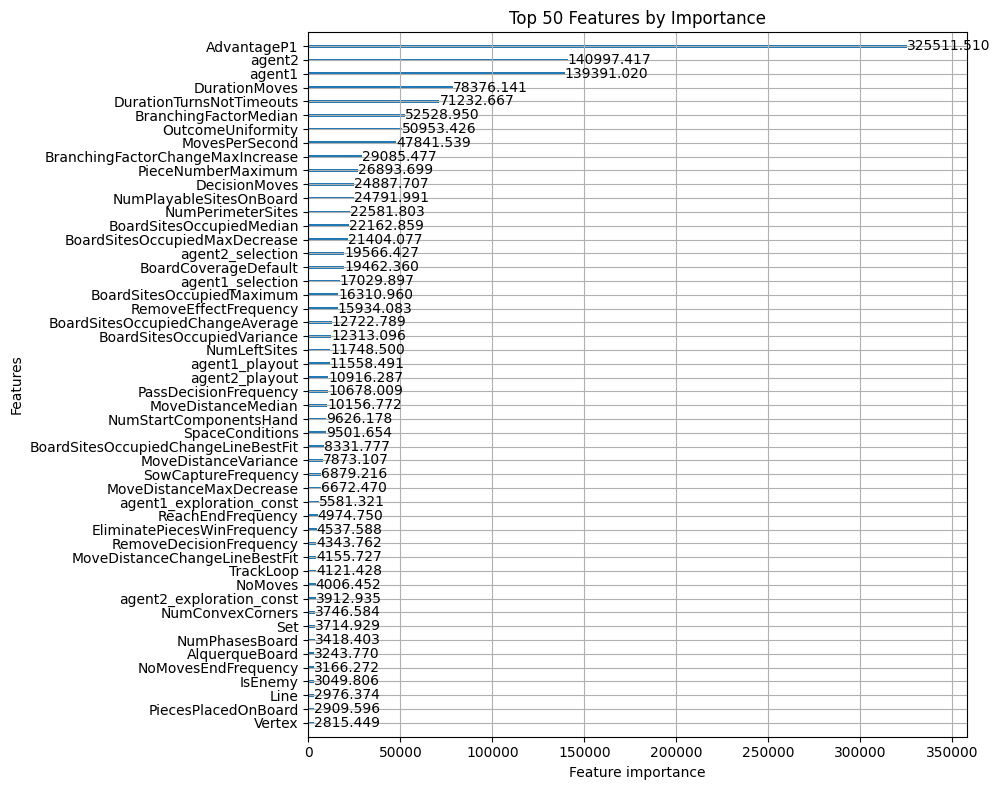

Fold 1 - RMSE: 0.42977876869219145
Fold 2


[100]	valid_0's rmse: 0.508714


[200]	valid_0's rmse: 0.485507


[300]	valid_0's rmse: 0.472481


[400]	valid_0's rmse: 0.464398


[500]	valid_0's rmse: 0.459203


[600]	valid_0's rmse: 0.454964


[700]	valid_0's rmse: 0.451568


[800]	valid_0's rmse: 0.448676


[900]	valid_0's rmse: 0.445916


[1000]	valid_0's rmse: 0.443531


[1100]	valid_0's rmse: 0.441552


[1200]	valid_0's rmse: 0.439752


[1300]	valid_0's rmse: 0.438082


[1400]	valid_0's rmse: 0.436652


[1500]	valid_0's rmse: 0.435572


[1600]	valid_0's rmse: 0.434588


[1700]	valid_0's rmse: 0.433675


[1800]	valid_0's rmse: 0.432802


[1900]	valid_0's rmse: 0.432187


[2000]	valid_0's rmse: 0.431484


[2100]	valid_0's rmse: 0.430638


[2200]	valid_0's rmse: 0.429966


[2300]	valid_0's rmse: 0.429409


[2400]	valid_0's rmse: 0.428919


[2500]	valid_0's rmse: 0.428412


[2600]	valid_0's rmse: 0.42783


[2700]	valid_0's rmse: 0.427351


[2800]	valid_0's rmse: 0.426928


[2900]	valid_0's rmse: 0.426526


[3000]	valid_0's rmse: 0.426107


[3100]	valid_0's rmse: 0.425812


[3200]	valid_0's rmse: 0.425371


[3300]	valid_0's rmse: 0.425186


[3400]	valid_0's rmse: 0.424923


[3500]	valid_0's rmse: 0.424714


[3600]	valid_0's rmse: 0.424424


[3700]	valid_0's rmse: 0.424228


[3800]	valid_0's rmse: 0.423926


[3900]	valid_0's rmse: 0.423699


[4000]	valid_0's rmse: 0.423439


[4100]	valid_0's rmse: 0.423284


[4200]	valid_0's rmse: 0.423162


[4300]	valid_0's rmse: 0.422886


[4400]	valid_0's rmse: 0.42256


[4500]	valid_0's rmse: 0.422374


[4600]	valid_0's rmse: 0.422198


[4700]	valid_0's rmse: 0.421982


[4800]	valid_0's rmse: 0.42177


[4900]	valid_0's rmse: 0.421685


[5000]	valid_0's rmse: 0.421636


[5100]	valid_0's rmse: 0.421538


[5200]	valid_0's rmse: 0.421426


[5300]	valid_0's rmse: 0.421332


[5400]	valid_0's rmse: 0.421225


[5500]	valid_0's rmse: 0.421116


[5600]	valid_0's rmse: 0.421071


[5700]	valid_0's rmse: 0.420959


[5800]	valid_0's rmse: 0.420811


[5900]	valid_0's rmse: 0.420612


[6000]	valid_0's rmse: 0.420537


[6100]	valid_0's rmse: 0.420445


[6200]	valid_0's rmse: 0.420384


[6300]	valid_0's rmse: 0.420318


[6400]	valid_0's rmse: 0.4203


[6500]	valid_0's rmse: 0.420132


[6600]	valid_0's rmse: 0.420096


[6700]	valid_0's rmse: 0.419977


[6800]	valid_0's rmse: 0.419905


[6900]	valid_0's rmse: 0.419855


[7000]	valid_0's rmse: 0.419842


[7100]	valid_0's rmse: 0.419826


[7200]	valid_0's rmse: 0.419776


[7300]	valid_0's rmse: 0.419711


[7400]	valid_0's rmse: 0.41964


[7500]	valid_0's rmse: 0.419594


[7600]	valid_0's rmse: 0.419524


[7700]	valid_0's rmse: 0.419538


[7800]	valid_0's rmse: 0.419543


[7900]	valid_0's rmse: 0.419484


[8000]	valid_0's rmse: 0.41945


[8100]	valid_0's rmse: 0.419443


[8200]	valid_0's rmse: 0.419412


[8300]	valid_0's rmse: 0.419374


[8400]	valid_0's rmse: 0.419378


[8500]	valid_0's rmse: 0.419398


[8600]	valid_0's rmse: 0.419355


[8700]	valid_0's rmse: 0.419328


[8800]	valid_0's rmse: 0.419307


[8900]	valid_0's rmse: 0.419251


[9000]	valid_0's rmse: 0.419242


[9100]	valid_0's rmse: 0.419218


[9200]	valid_0's rmse: 0.419194


[9300]	valid_0's rmse: 0.419174


[9400]	valid_0's rmse: 0.419172


[9500]	valid_0's rmse: 0.419111


[9600]	valid_0's rmse: 0.419079


[9700]	valid_0's rmse: 0.419088


[9800]	valid_0's rmse: 0.419046


[9900]	valid_0's rmse: 0.419028


[10000]	valid_0's rmse: 0.419003


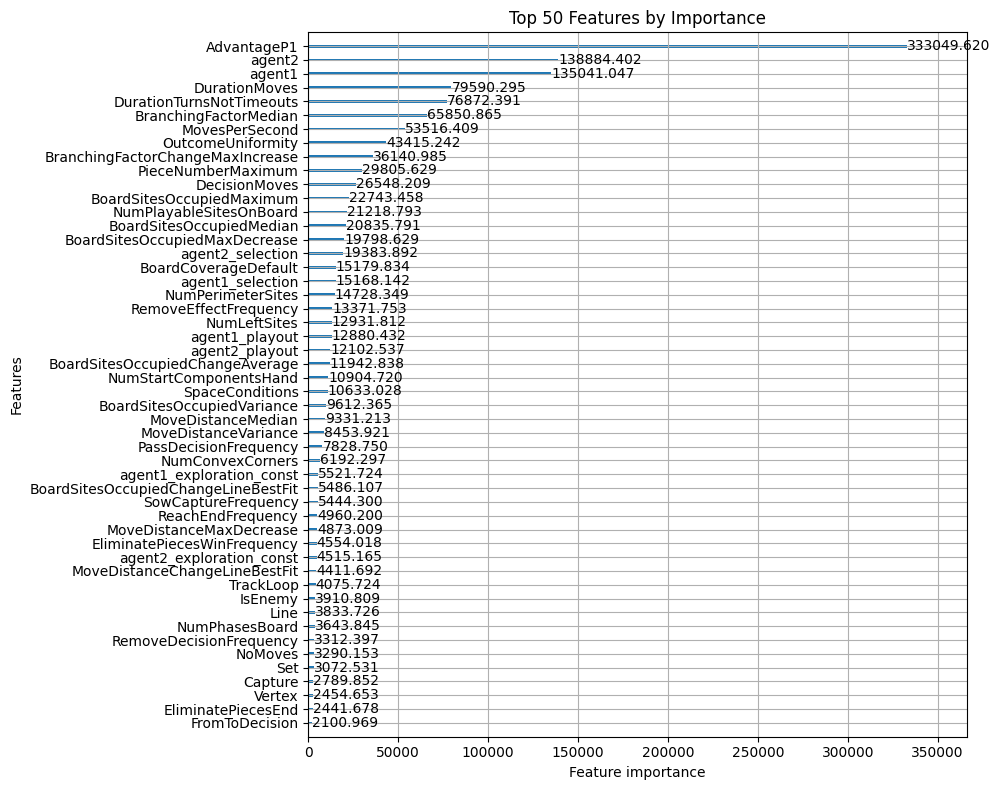

Fold 2 - RMSE: 0.4185953480153587
Fold 3


[100]	valid_0's rmse: 0.495501


[200]	valid_0's rmse: 0.474041


[300]	valid_0's rmse: 0.463263


[400]	valid_0's rmse: 0.45602


[500]	valid_0's rmse: 0.451835


[600]	valid_0's rmse: 0.448633


[700]	valid_0's rmse: 0.445709


[800]	valid_0's rmse: 0.443354


[900]	valid_0's rmse: 0.441488


[1000]	valid_0's rmse: 0.439895


[1100]	valid_0's rmse: 0.438485


[1200]	valid_0's rmse: 0.437218


[1300]	valid_0's rmse: 0.436044


[1400]	valid_0's rmse: 0.435252


[1500]	valid_0's rmse: 0.434336


[1600]	valid_0's rmse: 0.433524


[1700]	valid_0's rmse: 0.432829


[1800]	valid_0's rmse: 0.432087


[1900]	valid_0's rmse: 0.431519


[2000]	valid_0's rmse: 0.430955


[2100]	valid_0's rmse: 0.430563


[2200]	valid_0's rmse: 0.430061


[2300]	valid_0's rmse: 0.429727


[2400]	valid_0's rmse: 0.429336


[2500]	valid_0's rmse: 0.428883


[2600]	valid_0's rmse: 0.428572


[2700]	valid_0's rmse: 0.428292


[2800]	valid_0's rmse: 0.427974


[2900]	valid_0's rmse: 0.427696


[3000]	valid_0's rmse: 0.427508


[3100]	valid_0's rmse: 0.427291


[3200]	valid_0's rmse: 0.427016


[3300]	valid_0's rmse: 0.426679


[3400]	valid_0's rmse: 0.426383


[3500]	valid_0's rmse: 0.426103


[3600]	valid_0's rmse: 0.425964


[3700]	valid_0's rmse: 0.425798


[3800]	valid_0's rmse: 0.425617


[3900]	valid_0's rmse: 0.425508


[4000]	valid_0's rmse: 0.425287


[4100]	valid_0's rmse: 0.425117


[4200]	valid_0's rmse: 0.424983


[4300]	valid_0's rmse: 0.424826


[4400]	valid_0's rmse: 0.42476


[4500]	valid_0's rmse: 0.424602


[4600]	valid_0's rmse: 0.424457


[4700]	valid_0's rmse: 0.424436


[4800]	valid_0's rmse: 0.424288


[4900]	valid_0's rmse: 0.424179


[5000]	valid_0's rmse: 0.424037


[5100]	valid_0's rmse: 0.423905


[5200]	valid_0's rmse: 0.423852


[5300]	valid_0's rmse: 0.423728


[5400]	valid_0's rmse: 0.423668


[5500]	valid_0's rmse: 0.423533


[5600]	valid_0's rmse: 0.423483


[5700]	valid_0's rmse: 0.423403


[5800]	valid_0's rmse: 0.423336


[5900]	valid_0's rmse: 0.423299


[6000]	valid_0's rmse: 0.423258


[6100]	valid_0's rmse: 0.423135


[6200]	valid_0's rmse: 0.423098


[6300]	valid_0's rmse: 0.422996


[6400]	valid_0's rmse: 0.422943


[6500]	valid_0's rmse: 0.422913


[6600]	valid_0's rmse: 0.422789


[6700]	valid_0's rmse: 0.422775


[6800]	valid_0's rmse: 0.422753


[6900]	valid_0's rmse: 0.422797


[7000]	valid_0's rmse: 0.422786


[7100]	valid_0's rmse: 0.422694


[7200]	valid_0's rmse: 0.422674


[7300]	valid_0's rmse: 0.422727


[7400]	valid_0's rmse: 0.422629


[7500]	valid_0's rmse: 0.422598


[7600]	valid_0's rmse: 0.422537


[7700]	valid_0's rmse: 0.422478


[7800]	valid_0's rmse: 0.422436


[7900]	valid_0's rmse: 0.422367


[8000]	valid_0's rmse: 0.422381


[8100]	valid_0's rmse: 0.422311


[8200]	valid_0's rmse: 0.422148


[8300]	valid_0's rmse: 0.422119


[8400]	valid_0's rmse: 0.42204


[8500]	valid_0's rmse: 0.42193


[8600]	valid_0's rmse: 0.421928


[8700]	valid_0's rmse: 0.421947


[8800]	valid_0's rmse: 0.421878


[8900]	valid_0's rmse: 0.421869


[9000]	valid_0's rmse: 0.421799


[9100]	valid_0's rmse: 0.421799


[9200]	valid_0's rmse: 0.421795


[9300]	valid_0's rmse: 0.421736


[9400]	valid_0's rmse: 0.421677


[9500]	valid_0's rmse: 0.421634


[9600]	valid_0's rmse: 0.42162


[9700]	valid_0's rmse: 0.421608


[9800]	valid_0's rmse: 0.421583


[9900]	valid_0's rmse: 0.421559


[10000]	valid_0's rmse: 0.421569


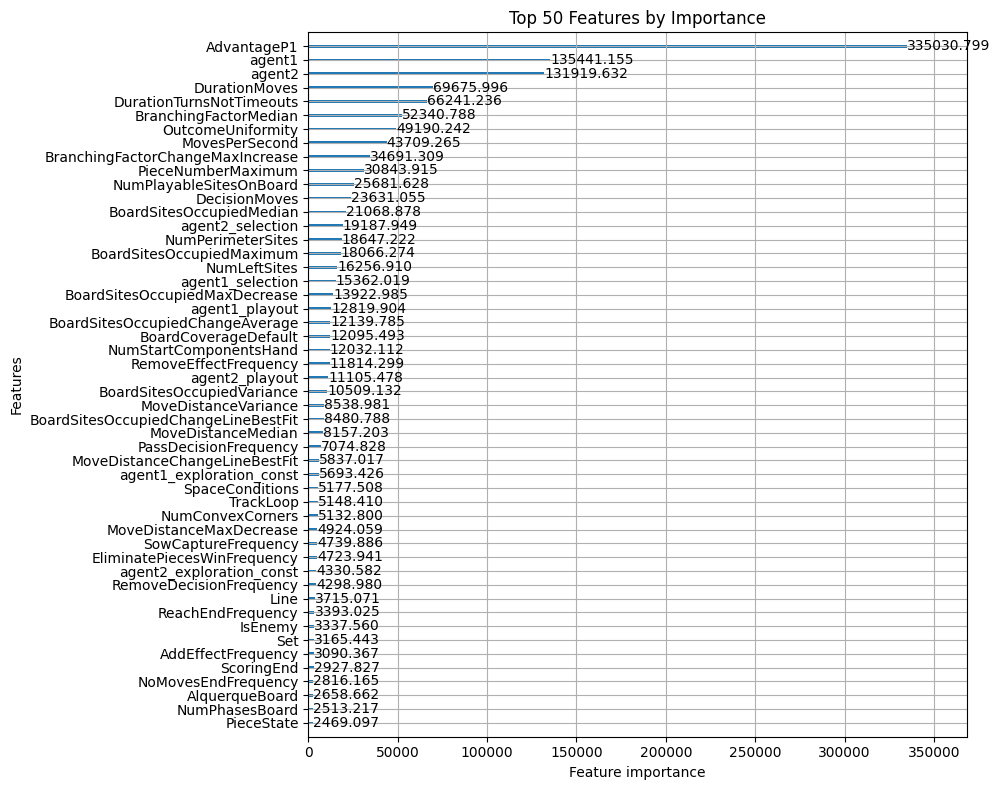

Fold 3 - RMSE: 0.42107734546171854
Fold 4


[100]	valid_0's rmse: 0.490736


[200]	valid_0's rmse: 0.469074


[300]	valid_0's rmse: 0.459096


[400]	valid_0's rmse: 0.45232


[500]	valid_0's rmse: 0.448193


[600]	valid_0's rmse: 0.444942


[700]	valid_0's rmse: 0.441916


[800]	valid_0's rmse: 0.439776


[900]	valid_0's rmse: 0.437975


[1000]	valid_0's rmse: 0.436654


[1100]	valid_0's rmse: 0.435779


[1200]	valid_0's rmse: 0.434814


[1300]	valid_0's rmse: 0.434187


[1400]	valid_0's rmse: 0.433297


[1500]	valid_0's rmse: 0.432677


[1600]	valid_0's rmse: 0.431851


[1700]	valid_0's rmse: 0.431258


[1800]	valid_0's rmse: 0.43075


[1900]	valid_0's rmse: 0.430256


[2000]	valid_0's rmse: 0.429862


[2100]	valid_0's rmse: 0.429582


[2200]	valid_0's rmse: 0.429247


[2300]	valid_0's rmse: 0.42888


[2400]	valid_0's rmse: 0.42865


[2500]	valid_0's rmse: 0.428366


[2600]	valid_0's rmse: 0.428004


[2700]	valid_0's rmse: 0.427789


[2800]	valid_0's rmse: 0.427691


[2900]	valid_0's rmse: 0.427502


[3000]	valid_0's rmse: 0.427428


[3100]	valid_0's rmse: 0.427328


[3200]	valid_0's rmse: 0.42722


[3300]	valid_0's rmse: 0.427132


[3400]	valid_0's rmse: 0.42693


[3500]	valid_0's rmse: 0.42676


[3600]	valid_0's rmse: 0.426599


[3700]	valid_0's rmse: 0.42649


[3800]	valid_0's rmse: 0.426376


[3900]	valid_0's rmse: 0.426254


[4000]	valid_0's rmse: 0.426106


[4100]	valid_0's rmse: 0.426035


[4200]	valid_0's rmse: 0.425886


[4300]	valid_0's rmse: 0.425783


[4400]	valid_0's rmse: 0.425626


[4500]	valid_0's rmse: 0.425629


[4600]	valid_0's rmse: 0.425567


[4700]	valid_0's rmse: 0.425468


[4800]	valid_0's rmse: 0.425342


[4900]	valid_0's rmse: 0.425249


[5000]	valid_0's rmse: 0.425234


[5100]	valid_0's rmse: 0.425122


[5200]	valid_0's rmse: 0.424942


[5300]	valid_0's rmse: 0.424826


[5400]	valid_0's rmse: 0.424662


[5500]	valid_0's rmse: 0.424695


[5600]	valid_0's rmse: 0.424597


[5700]	valid_0's rmse: 0.424596


[5800]	valid_0's rmse: 0.424614


[5900]	valid_0's rmse: 0.424543


[6000]	valid_0's rmse: 0.424512


[6100]	valid_0's rmse: 0.424431


[6200]	valid_0's rmse: 0.424405


[6300]	valid_0's rmse: 0.424314


[6400]	valid_0's rmse: 0.42426


[6500]	valid_0's rmse: 0.424183


[6600]	valid_0's rmse: 0.424148


[6700]	valid_0's rmse: 0.424136


[6800]	valid_0's rmse: 0.424134


[6900]	valid_0's rmse: 0.424122


[7000]	valid_0's rmse: 0.424098


[7100]	valid_0's rmse: 0.42413


[7200]	valid_0's rmse: 0.424089


[7300]	valid_0's rmse: 0.424073


[7400]	valid_0's rmse: 0.424072


[7500]	valid_0's rmse: 0.424044


[7600]	valid_0's rmse: 0.424022


[7700]	valid_0's rmse: 0.423982


[7800]	valid_0's rmse: 0.423967


[7900]	valid_0's rmse: 0.423963


[8000]	valid_0's rmse: 0.423975


[8100]	valid_0's rmse: 0.423988


[8200]	valid_0's rmse: 0.423982


[8300]	valid_0's rmse: 0.423963


[8400]	valid_0's rmse: 0.423896


[8500]	valid_0's rmse: 0.423858


[8600]	valid_0's rmse: 0.423878


[8700]	valid_0's rmse: 0.423854


[8800]	valid_0's rmse: 0.423759


[8900]	valid_0's rmse: 0.423766


[9000]	valid_0's rmse: 0.42376


[9100]	valid_0's rmse: 0.423811


[9200]	valid_0's rmse: 0.423792


[9300]	valid_0's rmse: 0.423764


[9400]	valid_0's rmse: 0.423757


[9500]	valid_0's rmse: 0.42381


[9600]	valid_0's rmse: 0.423808


[9700]	valid_0's rmse: 0.423868


[9800]	valid_0's rmse: 0.423826


[9900]	valid_0's rmse: 0.423782


[10000]	valid_0's rmse: 0.423796


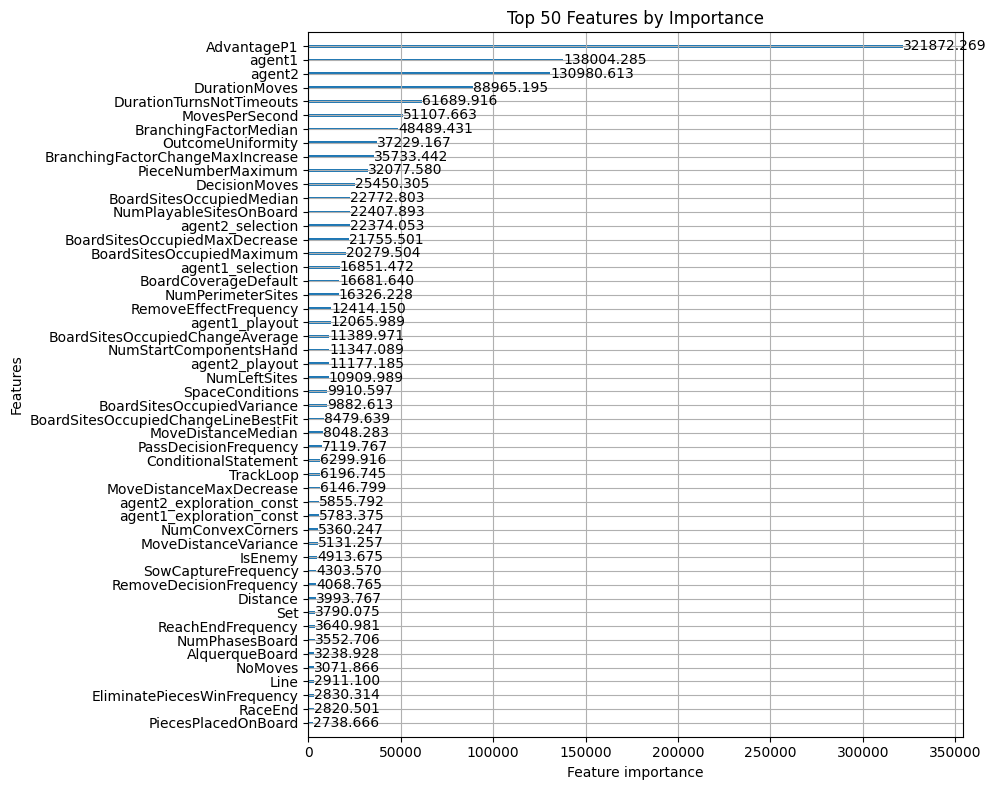

Fold 4 - RMSE: 0.4231582557171447
Fold 5


[100]	valid_0's rmse: 0.510653


[200]	valid_0's rmse: 0.486245


[300]	valid_0's rmse: 0.471551


[400]	valid_0's rmse: 0.461561


[500]	valid_0's rmse: 0.455573


[600]	valid_0's rmse: 0.450975


[700]	valid_0's rmse: 0.447449


[800]	valid_0's rmse: 0.4446


[900]	valid_0's rmse: 0.441989


[1000]	valid_0's rmse: 0.44011


[1100]	valid_0's rmse: 0.438313


[1200]	valid_0's rmse: 0.436858


[1300]	valid_0's rmse: 0.43535


[1400]	valid_0's rmse: 0.434054


[1500]	valid_0's rmse: 0.433172


[1600]	valid_0's rmse: 0.432216


[1700]	valid_0's rmse: 0.431383


[1800]	valid_0's rmse: 0.430614


[1900]	valid_0's rmse: 0.429891


[2000]	valid_0's rmse: 0.42921


[2100]	valid_0's rmse: 0.42854


[2200]	valid_0's rmse: 0.427947


[2300]	valid_0's rmse: 0.427314


[2400]	valid_0's rmse: 0.426767


[2500]	valid_0's rmse: 0.426309


[2600]	valid_0's rmse: 0.425886


[2700]	valid_0's rmse: 0.425325


[2800]	valid_0's rmse: 0.424979


[2900]	valid_0's rmse: 0.424514


[3000]	valid_0's rmse: 0.42415


[3100]	valid_0's rmse: 0.423805


[3200]	valid_0's rmse: 0.423414


[3300]	valid_0's rmse: 0.423214


[3400]	valid_0's rmse: 0.422911


[3500]	valid_0's rmse: 0.422624


[3600]	valid_0's rmse: 0.422326


[3700]	valid_0's rmse: 0.422021


[3800]	valid_0's rmse: 0.421776


[3900]	valid_0's rmse: 0.421652


[4000]	valid_0's rmse: 0.421473


[4100]	valid_0's rmse: 0.42126


[4200]	valid_0's rmse: 0.421055


[4300]	valid_0's rmse: 0.420855


[4400]	valid_0's rmse: 0.420711


[4500]	valid_0's rmse: 0.420502


[4600]	valid_0's rmse: 0.420361


[4700]	valid_0's rmse: 0.420142


[4800]	valid_0's rmse: 0.419942


[4900]	valid_0's rmse: 0.419828


[5000]	valid_0's rmse: 0.419656


[5100]	valid_0's rmse: 0.41947


[5200]	valid_0's rmse: 0.419309


[5300]	valid_0's rmse: 0.419186


[5400]	valid_0's rmse: 0.418997


[5500]	valid_0's rmse: 0.41884


[5600]	valid_0's rmse: 0.418794


[5700]	valid_0's rmse: 0.418697


[5800]	valid_0's rmse: 0.418505


[5900]	valid_0's rmse: 0.418405


[6000]	valid_0's rmse: 0.418245


[6100]	valid_0's rmse: 0.418099


[6200]	valid_0's rmse: 0.41803


[6300]	valid_0's rmse: 0.417868


[6400]	valid_0's rmse: 0.41774


[6500]	valid_0's rmse: 0.41767


[6600]	valid_0's rmse: 0.417593


[6700]	valid_0's rmse: 0.417506


[6800]	valid_0's rmse: 0.417443


[6900]	valid_0's rmse: 0.417439


[7000]	valid_0's rmse: 0.41741


[7100]	valid_0's rmse: 0.417257


[7200]	valid_0's rmse: 0.41722


[7300]	valid_0's rmse: 0.417185


[7400]	valid_0's rmse: 0.417081


[7500]	valid_0's rmse: 0.417022


[7600]	valid_0's rmse: 0.416961


[7700]	valid_0's rmse: 0.416915


[7800]	valid_0's rmse: 0.416826


[7900]	valid_0's rmse: 0.416742


[8000]	valid_0's rmse: 0.416647


[8100]	valid_0's rmse: 0.416516


[8200]	valid_0's rmse: 0.416519


[8300]	valid_0's rmse: 0.416442


[8400]	valid_0's rmse: 0.41639


[8500]	valid_0's rmse: 0.416374


[8600]	valid_0's rmse: 0.416344


[8700]	valid_0's rmse: 0.41621


[8800]	valid_0's rmse: 0.416196


[8900]	valid_0's rmse: 0.416128


[9000]	valid_0's rmse: 0.416052


[9100]	valid_0's rmse: 0.416019


[9200]	valid_0's rmse: 0.415921


[9300]	valid_0's rmse: 0.415831


[9400]	valid_0's rmse: 0.415828


[9500]	valid_0's rmse: 0.415758


[9600]	valid_0's rmse: 0.415739


[9700]	valid_0's rmse: 0.415717


[9800]	valid_0's rmse: 0.415731


[9900]	valid_0's rmse: 0.415687


[10000]	valid_0's rmse: 0.415611


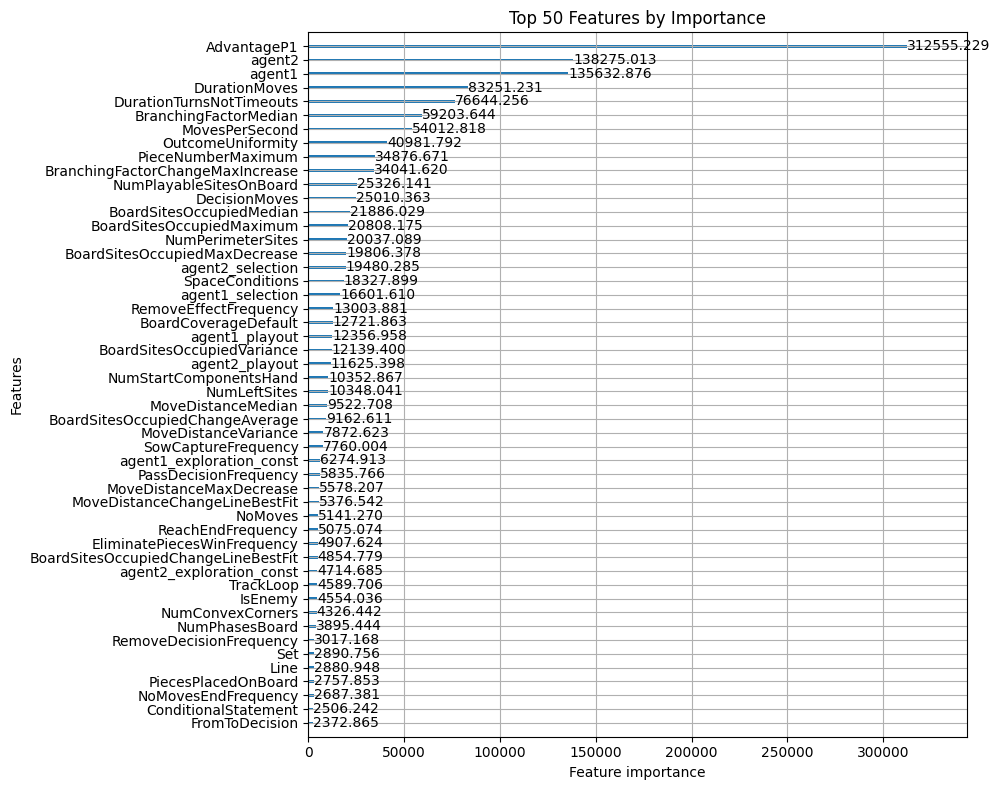

Fold 5 - RMSE: 0.41521450214752903
List of oof scores: [0.42977876869219145, 0.4185953480153587, 0.42107734546171854, 0.4231582557171447, 0.41521450214752903]
Average oof score: 0.4215648440067885


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv3.parquet', index=False)

In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")

CV1 OOF Scores:
Score: 0.4317
Score: 0.4424
Score: 0.4176
Score: 0.4276
Score: 0.4090
Average CV1 Score: 0.4257

CV2 OOF Scores:
Score: 0.4173
Score: 0.4036
Score: 0.4306
Score: 0.4348
Score: 0.4260
Average CV2 Score: 0.4225

CV3 OOF Scores:
Score: 0.4298
Score: 0.4186
Score: 0.4211
Score: 0.4232
Score: 0.4152
Average CV3 Score: 0.4216


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

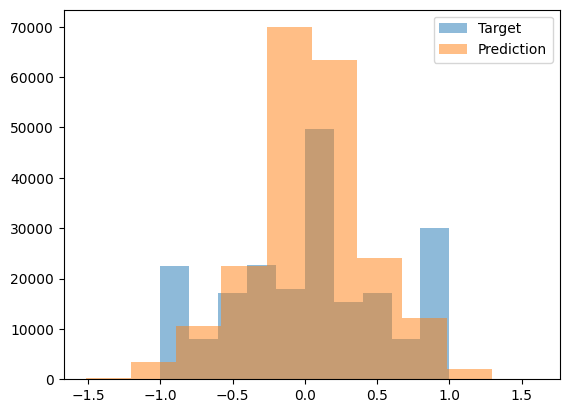

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame,):   
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Average predictions from all models
    predictions = [
        model.predict(test_processed[numerical_cols + categorical_cols]) 
        for model in trained_models
    ]
    predictions = np.mean(predictions, axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

shape: (3, 2)
┌────────┬────────────────┐
│ Id     ┆ utility_agent1 │
│ ---    ┆ ---            │
│ i64    ┆ f64            │
╞════════╪════════════════╡
│ 233234 ┆ 0.120377       │
│ 233235 ┆ -0.176499      │
│ 233236 ┆ -0.111892      │
└────────┴────────────────┘

In [20]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [21]:
# Save all artifacts needed for prediction
lightgbm_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols, 
    'encoder': encoder,
    'scaler': scaler
}

with open(f'./lightgbm_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(lightgbm_predict, f)

***